#Loading and Examining the Dataset

In this analysis, we explore a comprehensive dataset collected from distributed multi-sensor nodes in an indoor environment, aimed at detecting fire events. The dataset encompasses a wide range of sensor data, including **carbon dioxide** (CO2), **carbon monoxide** (CO), **hydrogen** (H2), various sizes of **particulate matter** (PM), **humidity**, **temperature**, **ultraviolet (UV) radiation**, and **volatile organic compounds** (VOCs). These sensors provide a multi-dimensional view of the environment, capturing the complex dynamics of indoor air quality and potential fire-related anomalies. Our goal is to analyze this dataset to identify linear dependencies among the sensor readings and determine which features are most closely related to fire events, as indicated by the `ternary_label`.

We will start by loading our data in a dataframe

In [ ]:
# Run this command if you load the notebook in Google Collab and make sure you correct the data_path bellow to your drive path
#from google.colab import drive
#drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import pandas as pd

data_path = '../data/Indoor Fire Dataset with Distributed Multi-Sensor Nodes.csv'

df = pd.read_csv(data_path)

df.head()

SyntaxError: unterminated string literal (detected at line 3) (<ipython-input-2-ff452c4b7bd7>, line 3)

# Data Exploration

The dataset consists of 305,304 entries and 19 columns, including various sensor readings (like CO2, CO, H2 levels, Humidity, different PM levels, Temperature, UV, VOC) and labels related to scenarios, anomalies, and a ternary classification of the situation (e.g., Background, Normal, Fire). The data also contains a Date and Sensor_ID for tracking measurements over time and across different sensor locations.

In [ ]:
print(f"Dataset Size: {df.shape}")
print(f"Number of Features: {df.shape[1]}")
print(f"Number of Entries: {df.shape[0]}")
df.info()

NameError: name 'df' is not defined

## Visualizing Sensor Data Over Time

The next step in our analysis is visualizing the sensor data to uncover patterns and insights related to fire detection. By plotting the levels of various room measurements over time, we manage to interpret how different environmental conditions fluctuate and how these fluctuations correlate with identified fire events. This visualization approach enables us to compare the sensor readings across three distinct scenarios: Background, Nuisance, and Fire. These comparisons are important in identifying signature patterns that might indicate the onset of a fire, differentiate between harmless anomalies and potential fire threats, and understand the baseline environmental conditions.

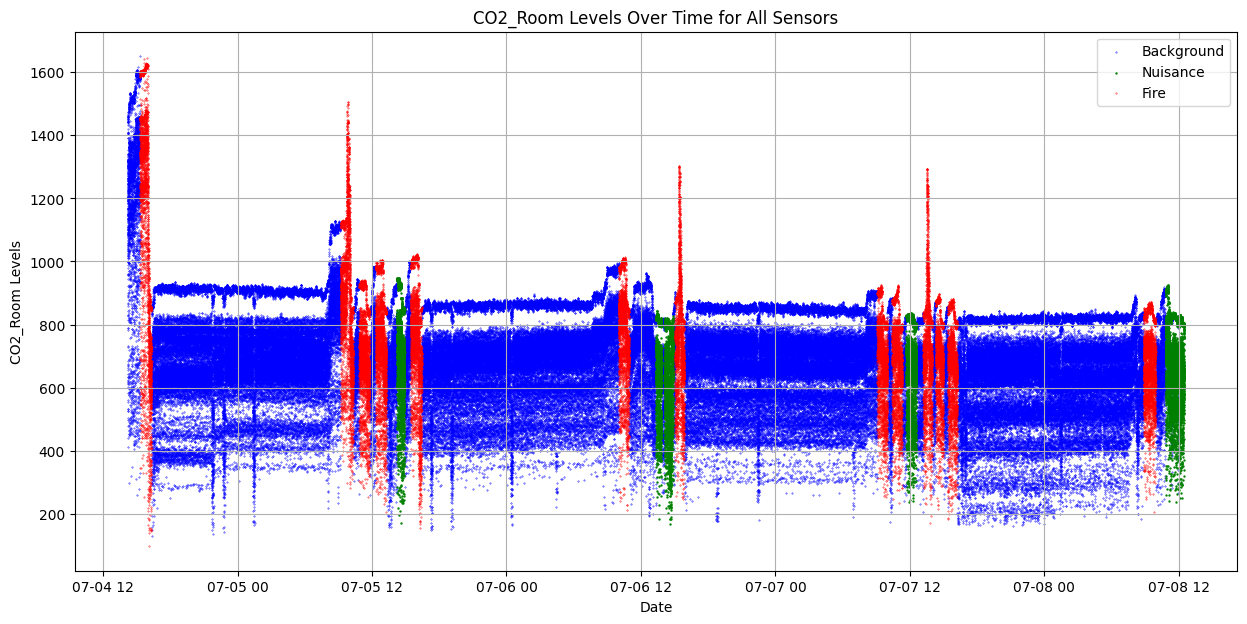

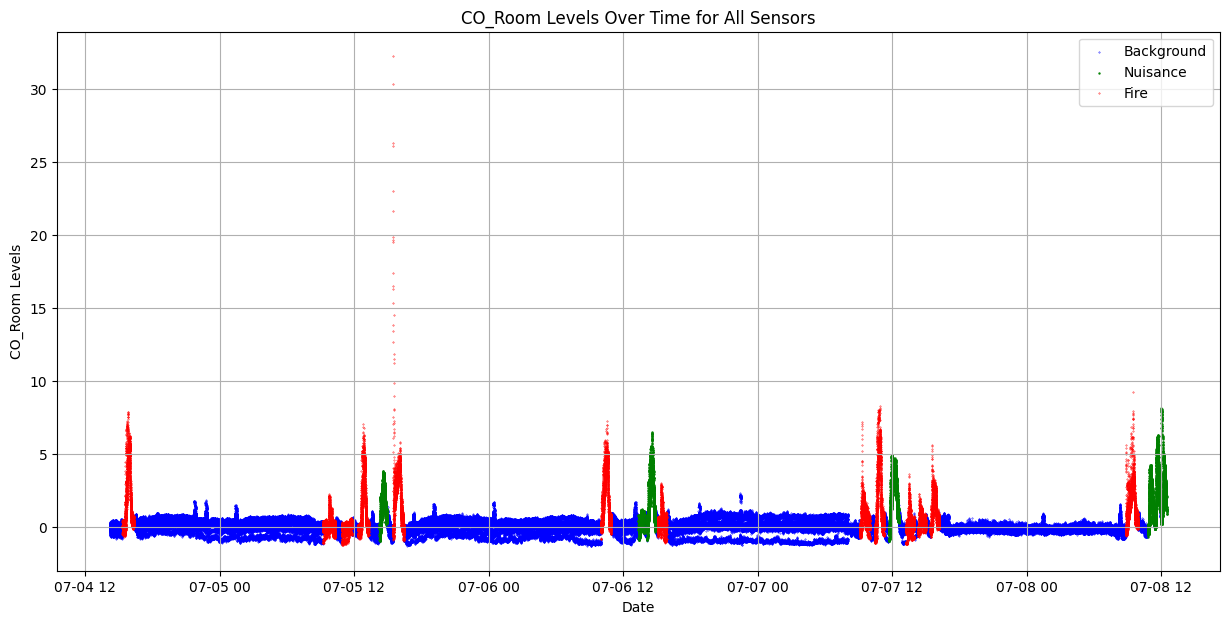

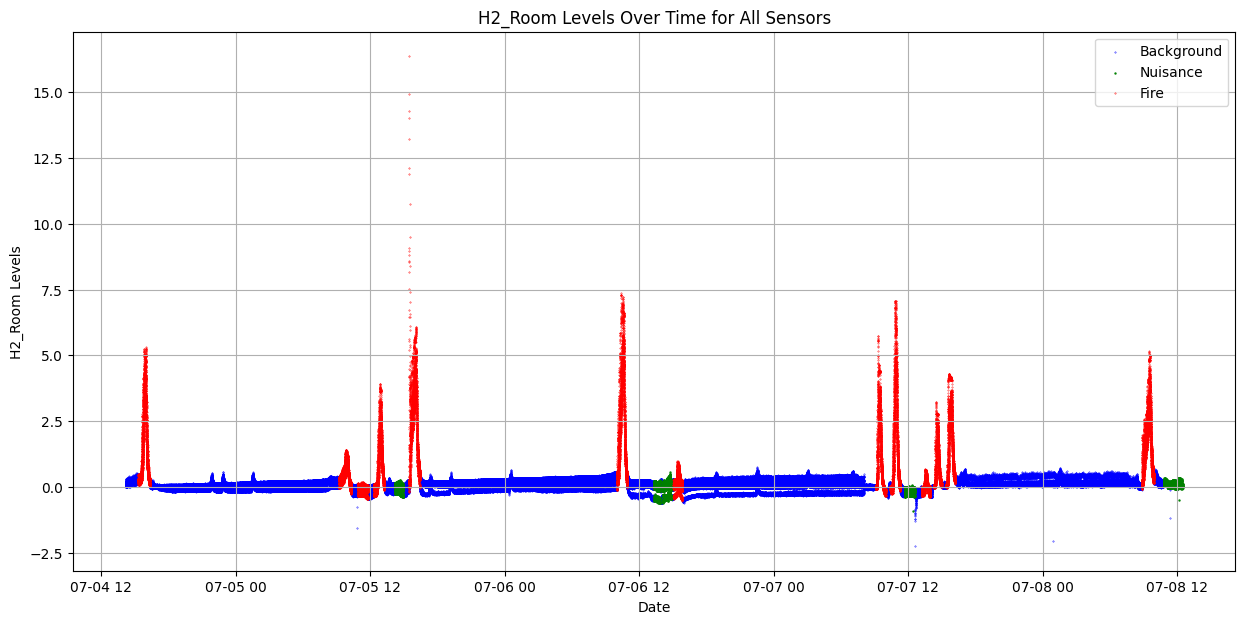

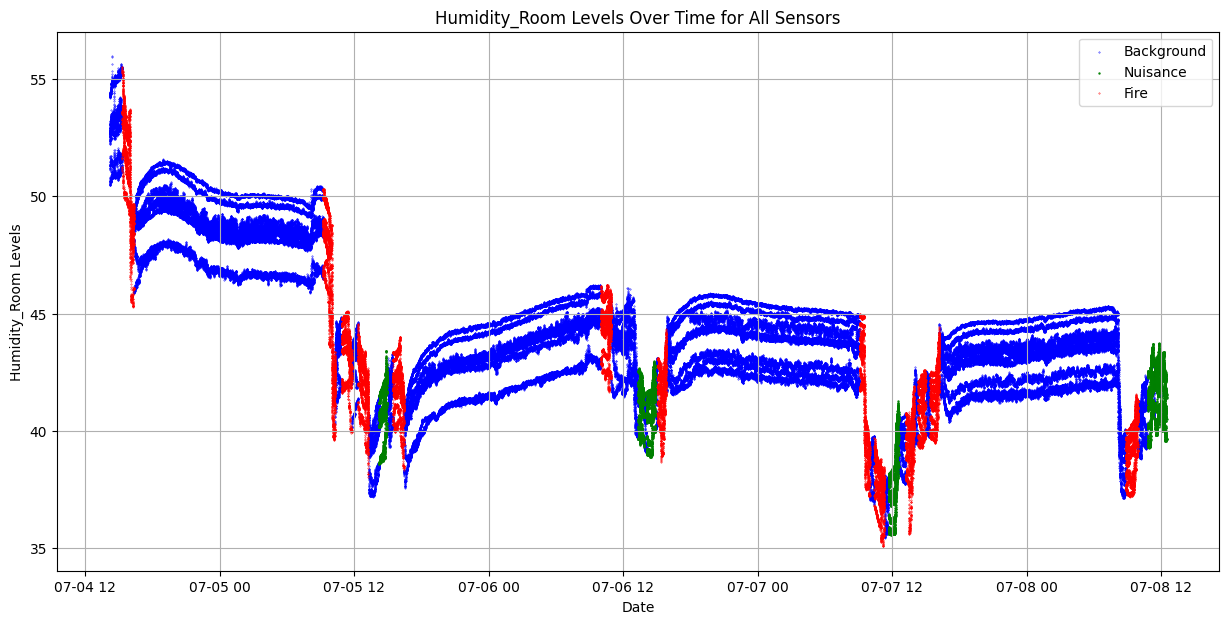

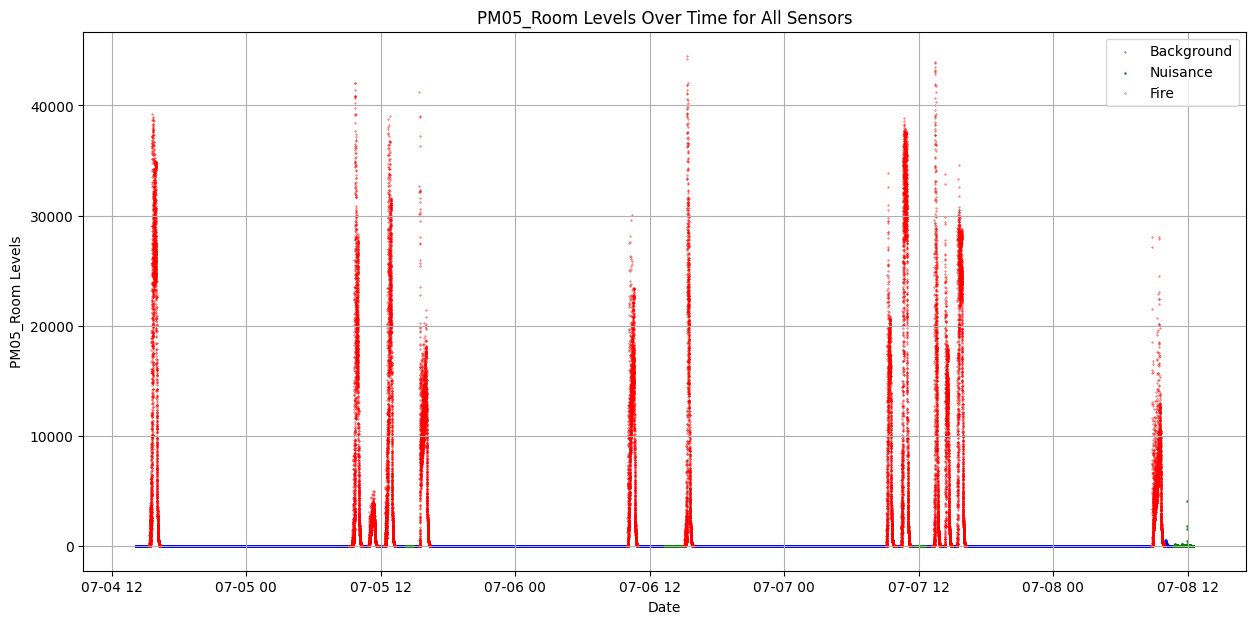

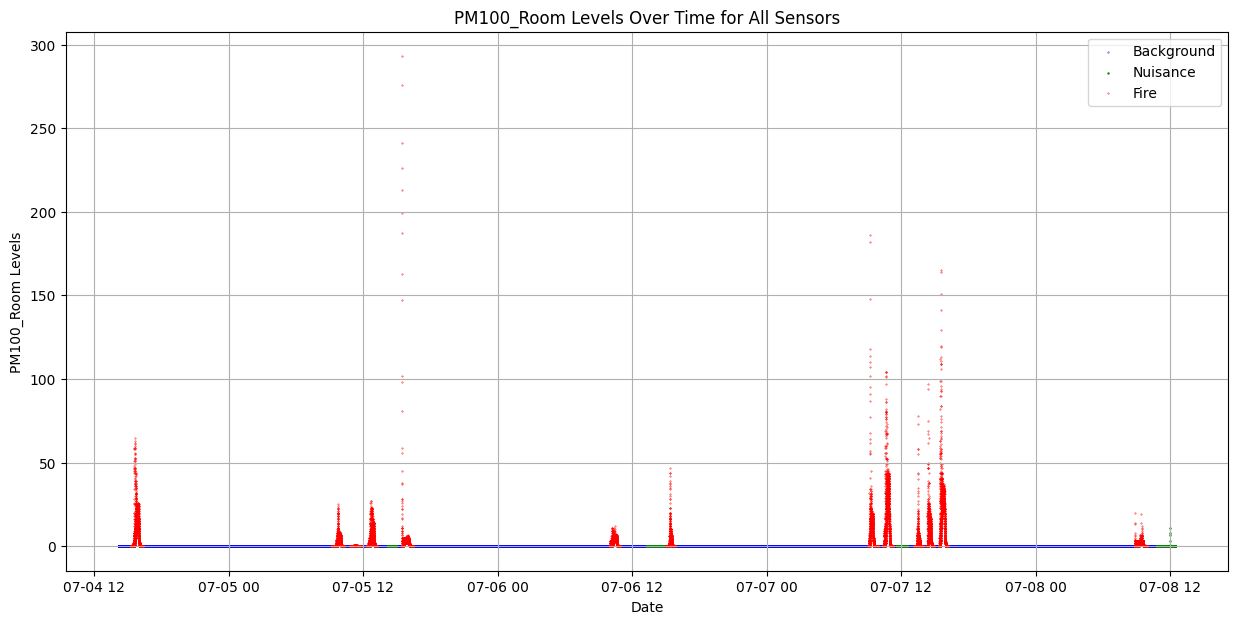

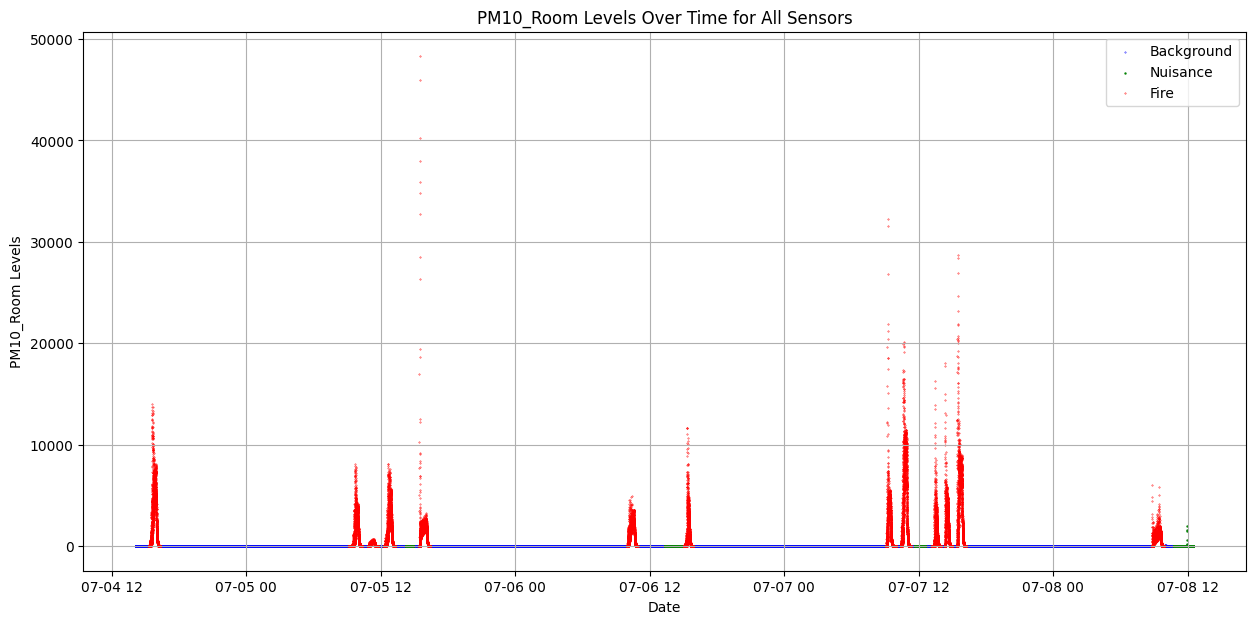

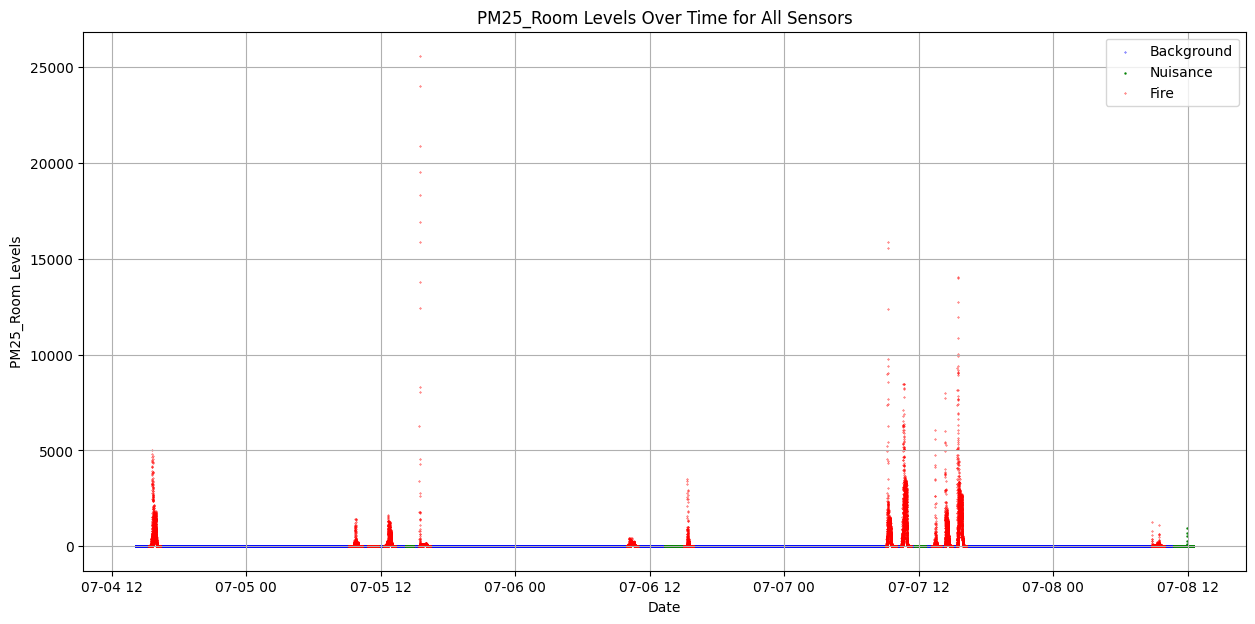

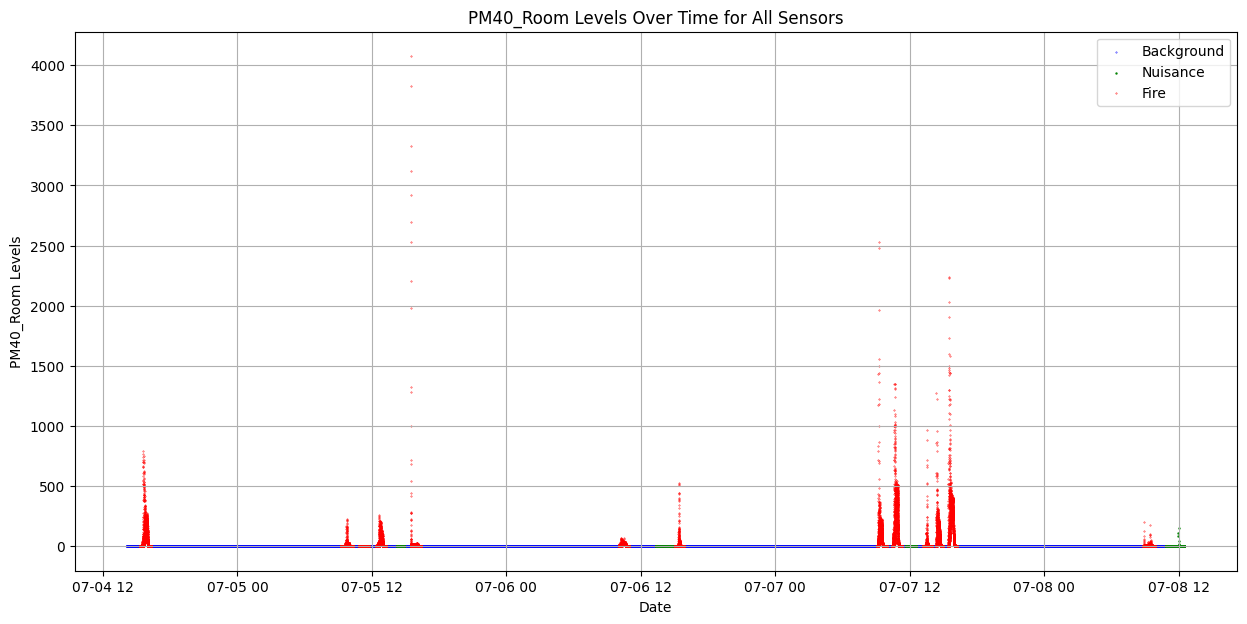

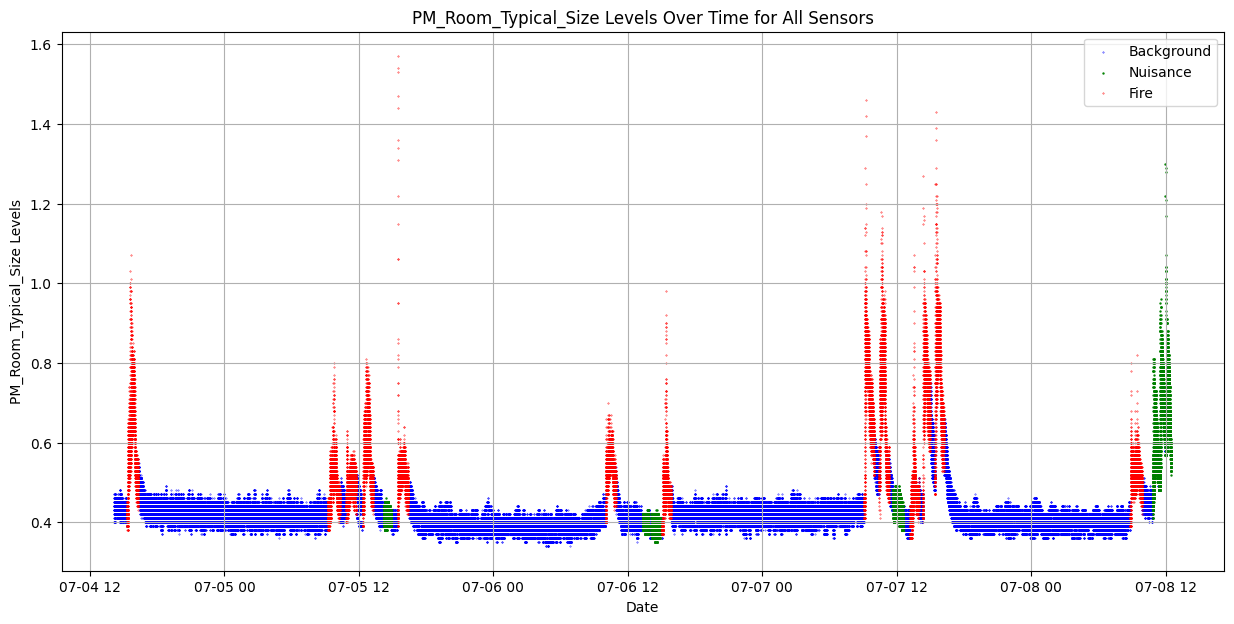

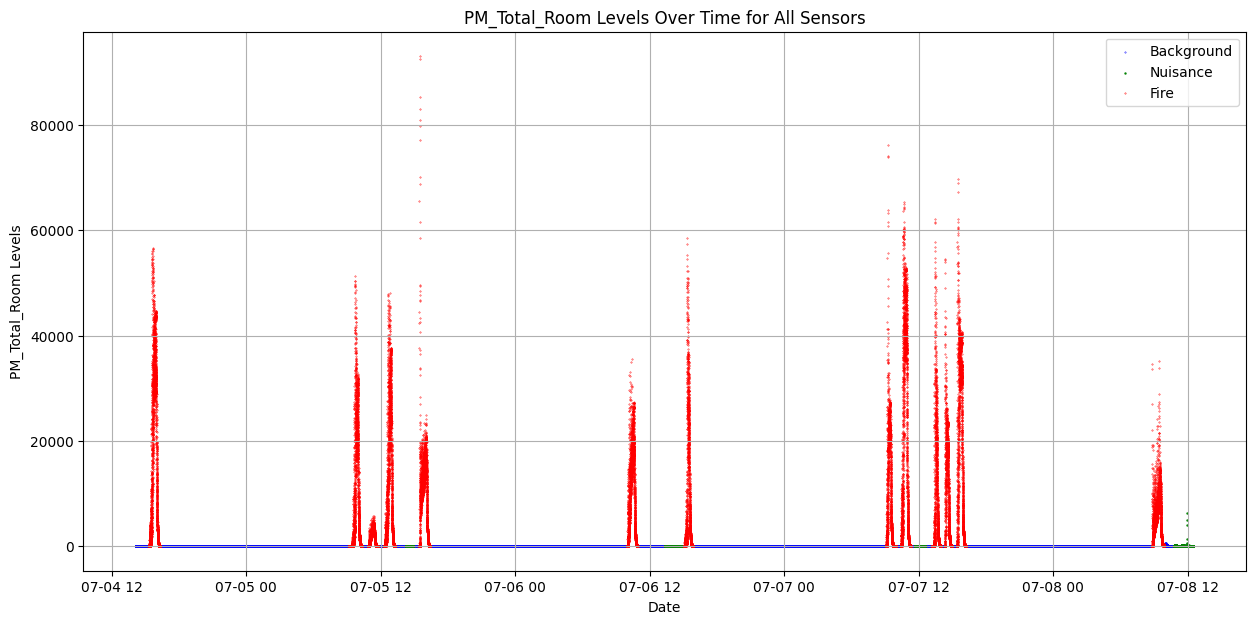

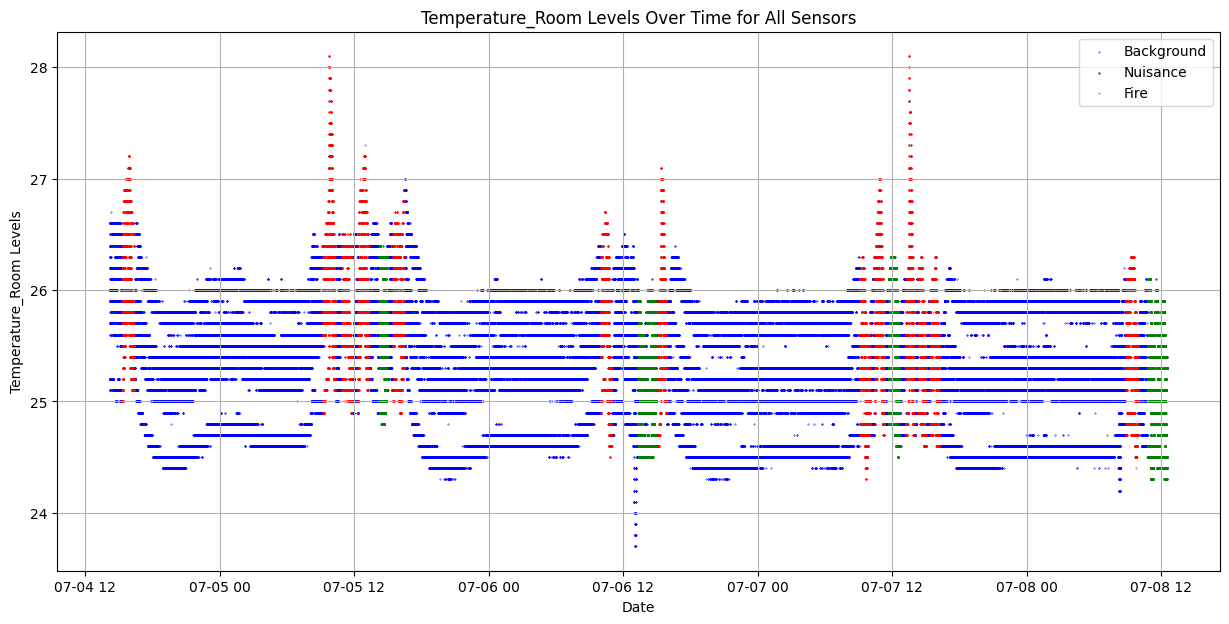

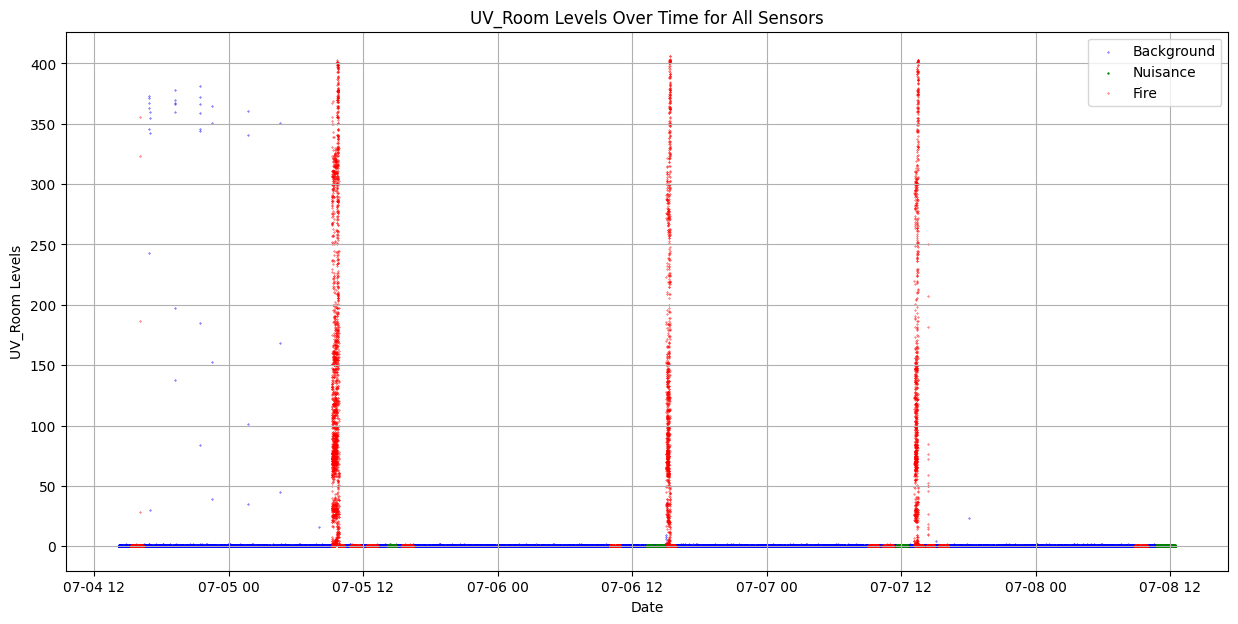

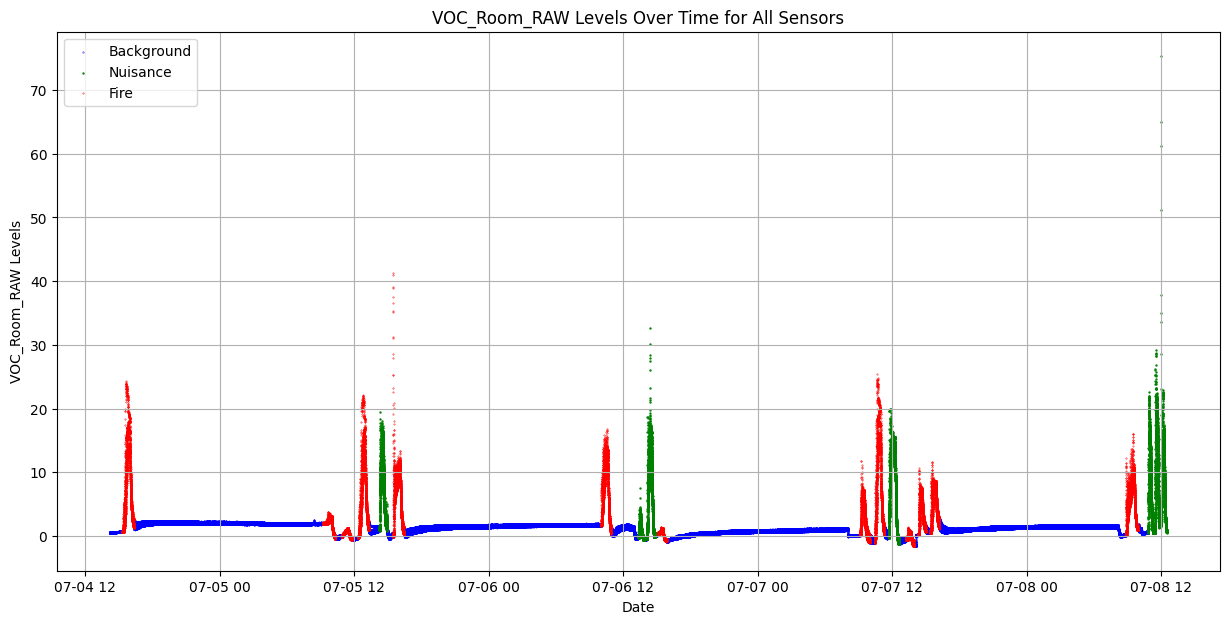

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extracting the column names that are related to room measurements
room_measurements = [col for col in df.columns if '_Room' in col]

# Separating data based on 'ternary_label'
background_data = df[df['ternary_label'] == 'Background']
nuisance_data = df[df['ternary_label'] == 'Nuisance']
fire_data = df[df['ternary_label'] == 'Fire']

# Iterate over each room measurement and plot the graph
for measurement in room_measurements:
    plt.figure(figsize=(15, 7))
    plt.scatter(background_data['Date'], background_data[measurement], color='blue', label='Background', s=0.1)
    plt.scatter(nuisance_data['Date'], nuisance_data[measurement], color='green', label='Nuisance', s=0.5)
    plt.scatter(fire_data['Date'], fire_data[measurement], color='red', label='Fire', s=0.1)
    plt.xlabel('Date')
    plt.ylabel(f'{measurement} Levels')
    plt.title(f'{measurement} Levels Over Time for All Sensors')
    plt.legend()
    plt.grid(True)
    plt.show()  # Show each plot separately


## Results Interpretation

Given the results of our plots, we can see that each feature fluctuates on a certain level when each scenario occurs (Nuisances and Fires). The fire spikes are more evident in our plots for each feature. However there's not a clear pattern which will help us identify which features affect the fire incident mostly. While these plots help us understand the nature of how the metrics behave across time, we might need to explore different techniques in order to understand which features affect the target value.

## Analyzing Feature Correlations with Fire Events

In this section we will study the relation between among features which indicate related to fire detection, this section delves into the correlation between sensor measurements and fire occurrences, focusing on identifying key predictors of fire. We also explore the linear dependencies among features to ascertain their relationships and potential redundancies.




First, we need to encode our target column values in order to facilitate the analysis process with proper labels.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'ternary_label' to encode
df['ternary_label_encoded'] = label_encoder.fit_transform(df['ternary_label'])

Next, we will study potential linear dependencies between our feature variables.

Given the nature of the dataset, let's start with a correlation analysis using Pearson correlation coefficients for each sensor reading against a numerical representation of the ternary_label. Since ternary_label is categorical, we'll first need to encode it numerically in a way that makes sense for linear analysis. For simplicity, we can map 'Background' to 0, 'Nuisance' to 1, and 'Fire' to 2, assuming an ordinal relationship.

In [ ]:
from scipy.stats import pearsonr

# Calculate Pearson correlation coefficients for each sensor reading against 'ternary_label_encoded'
correlations = {}
sensor_columns = [col for col in df.columns if '_Room' in col]  # Adjust as needed to target sensor columns

for col in sensor_columns:
    corr, _ = pearsonr(df[col], df['ternary_label_encoded'])
    correlations[col] = corr

# Convert the correlations dictionary to a DataFrame for easier visualization
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Pearson Correlation'])
correlation_df.sort_values(by='Pearson Correlation', ascending=False, inplace=True)

correlation_df

,Pearson Correlation
VOC_Room_RAW,0.560018
CO_Room,0.539228
PM_Room_Typical_Size,0.524277
PM05_Room,0.352814
PM_Total_Room,0.343720
PM10_Room,0.302176
H2_Room,0.285473
PM100_Room,0.224144
PM25_Room,0.181144
PM40_Room,0.176993


Based on the Pearson Correlation, we can observe the following insights:




*   **Positive Correlations**: Several sensor readings like `VOC_Room_RAW`, `CO_Room`, `PM_Room_Typical_Size`, and various particulate matter measurements have positive correlation coefficients ranging from moderate to strong. A positive correlation implies that as the sensor reading increases, the likelihood of the ternary_label being categorized as 'Fire' also increases, suggesting a linear dependency.
*   **Negative Correlation**: Humidity_Room shows a negative correlation, which indicates that higher humidity is inversely related to the likelihood of a fire event. This is also a form of linear dependency but in the opposite direction.
*   **Weak or No Correlation**: Some metics, such as CO2_Room, have coefficients close to zero, suggesting a weak or no linear relationship with the fire event status.

The strongest linear relationships are indicated by the highest absolute values of the correlation coefficients, seen in sensor readings like VOC_Room_RAW and CO_Room. These readings might be more reliable indicators of fire events compared to those with lower absolute correlation values.

Since our target column contains more than two distinct values (Background, Nuisance, Fire), traditional feature correlation analysis techniques may not suffice.


We will use the **ANOVA F-test** to analyse the relationship of our features with out targer variables.

Unlike correlation analysis, which measures the strength and direction of linear relationships between two continuous variables, the ANOVA F-test is designed to compare the means of three or more groups, making it ideal for scenarios where the target variable is categorical with multiple levels.

This method allows us to determine whether there are statistically significant differences in the means of the numerical features across the different categories of the target variable. By doing so, ANOVA can identify which features are most influential in distinguishing between these categories.

Next, we will proceed by performing the ANOVA F-test in our dataset.

In [ ]:
from sklearn.feature_selection import f_classif
import pandas as pd

X = df.drop(['ternary_label', 'Date', 'Sensor_ID', 'scenario_label', 'anomaly_label'], axis=1)
y = df['ternary_label_encoded']

# Perform ANOVA F-test
f_values, p_values = f_classif(X, y)

# Create a DataFrame to hold F-values and p-values
anova_results = pd.DataFrame({'Feature': X.columns, 'F-value': f_values, 'p-value': p_values})

# Sorting the results by F-value in descending order to see the most significant features at the top
anova_results_sorted = anova_results.sort_values(by='F-value', ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Next, we will proceed by visualising the ANOVA F-test results.

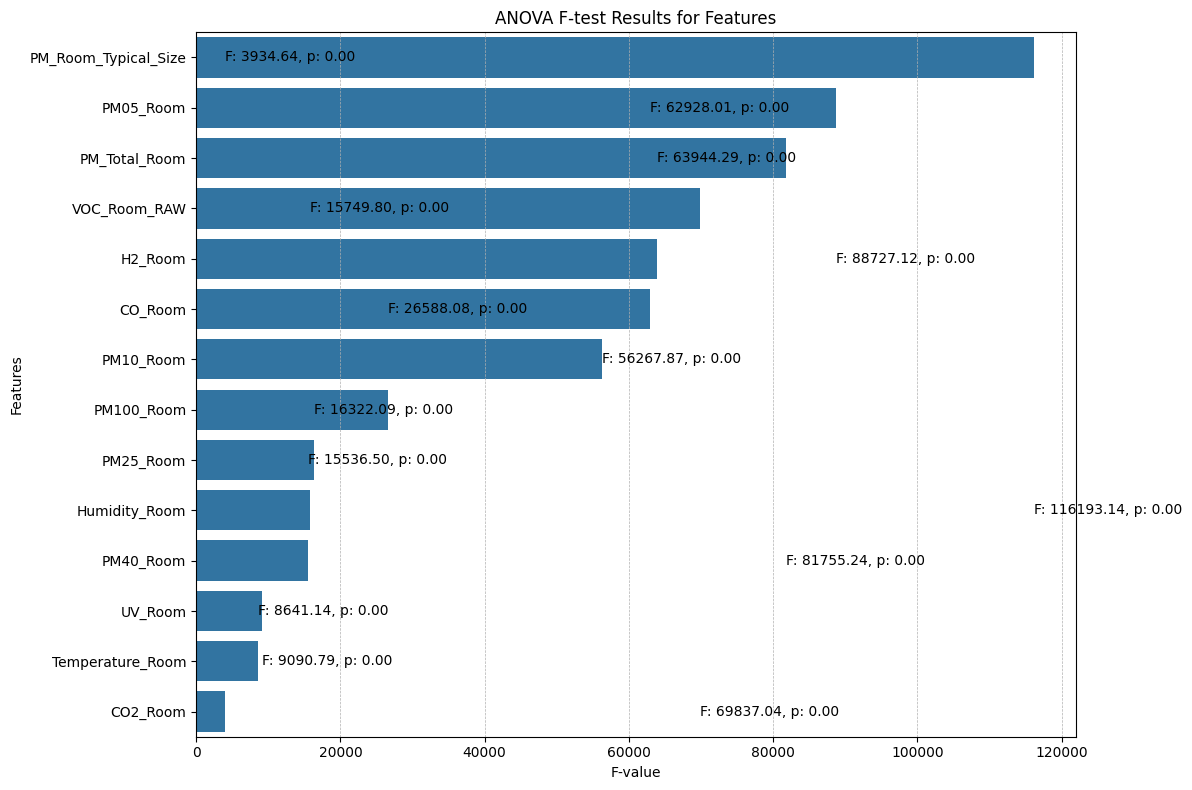

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Convert p - value results to numeric
anova_results_sorted['F-value'] = pd.to_numeric(anova_results_sorted['F-value'], errors='coerce')
anova_results_sorted['p-value'] = pd.to_numeric(anova_results_sorted['p-value'], errors='coerce')

# Filter out infinite values if any
anova_results_sorted = anova_results_sorted.replace([np.inf, -np.inf], np.nan).dropna(subset=['F-value', 'p-value'])

# Plotting
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='F-value', y='Feature', data=anova_results_sorted)

# Adding p-values as text on the bars
for index, row in anova_results_sorted.iterrows():
    # Convert scientific notation to float with two decimal points for readability
    f_value_formatted = "{:.2f}".format(row['F-value'])
    p_value_formatted = "{:.2f}".format(row['p-value'])
    plt.text(row['F-value'], index, f"F: {f_value_formatted}, p: {p_value_formatted}", color='black', va="center")

plt.xlabel('F-value')
plt.ylabel('Features')
plt.title('ANOVA F-test Results for Features')
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()

## Results Interpretation

Given the ANOVA F-test results we can interpret the following conclusions:


*   **Statistical Significance**: All features have p-values of 0.00, indicating significant differences in their average values across the categories of the ternary_label.
*   **Gaseous Measurements**: Gases such as `VOC_Room_RAW`, `H2_Room`, and `CO_Room` also show strong discriminative power, highlighting their relevance in fire scenarios.
*   **Comparative Importance**: Features like `CO2_Room`, `Temperature_Room`, and `UV_Room` have lower F-values, which implies they are comparatively less discriminative.
*   **Predictive Modeling**: The most significant features, indicated by higher F-values, should be prioritized for inclusion in fire detection predictive models.

Based on results from both feature analysis techniques we will put in our model the features with the highest correlation and the highest F-values from the ANOVA F-test. Those are the following, `PM_Total_Room`, `PM_Room_Typical_Size`, `PM10_Room`, `CO_Room`, `H2_Room`, `PM05_Room`, `VOC_Room_RAW`, `UV_Room`, `ternary_label`



# Assessing Class Imbalance

Understanding the distribution of classes in our dataset is a critical step before proceeding with predictive modeling. Class imbalance can significantly influence the performance of a model, as a disproportionate number of instances in one class can lead to a bias towards the majority class. In the context of fire detection, this could mean the model might be less sensitive to actual fire events if they are underrepresented. To ensure our model is well-equipped to recognize each scenario accurately, we must assess the class balance and consider implementing strategies like undersampling or oversampling if a significant imbalance is detected.

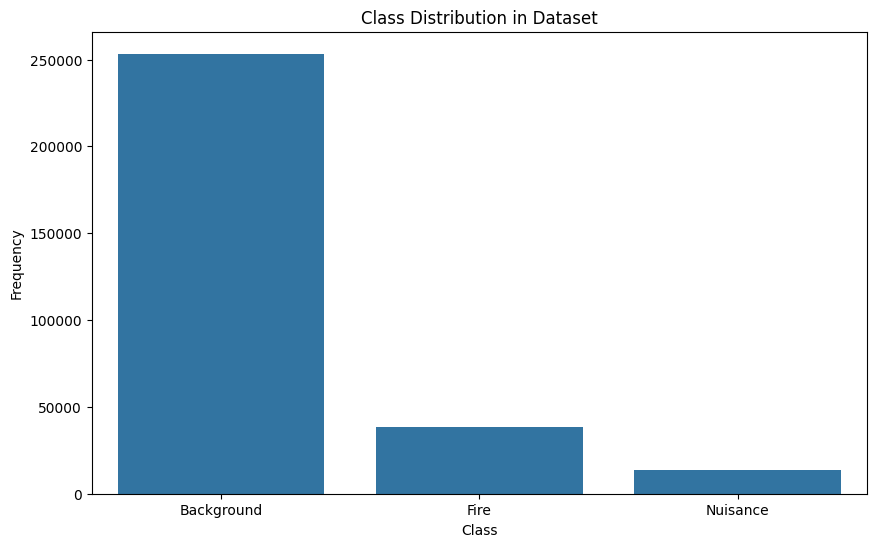

Background    253327
Fire           38148
Nuisance       13829
Name: ternary_label, dtype: int64


In [ ]:
class_counts = df['ternary_label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Display the class distribution
print(class_counts)

## Results Interpretation

We can derive the following insights given the class distribution above:



*   **Dominant Class**: The 'Background' class has the highest frequency, indicating that it is the most common label in the dataset. This suggests that the majority of data points correspond to normal conditions without a fire event.
*   **Minor Classes**: The 'Fire' class has a lower frequency compared to 'Background' but is more frequent than 'Nuisance'. This indicates that fire events are less common than normal conditions but occur more frequently than nuisance conditions in the dataset.
*   **Class Imbalance**: There is a clear imbalance between the classes, with 'Background' being the dominant class and 'Nuisance' the least represented. Such an imbalance can lead to a model that is biased towards predicting the majority class ('Background') and may not perform well in detecting the minority classes, particularly 'Nuisance'.
*   **Implications for Modeling**: Given the imbalance, machine learning models trained on this dataset might require techniques to address this issue, such as undersampling the majority class, oversampling the minority classes, or using algorithms that are less sensitive to class imbalance.

To address this, an undersampling technique is recommended to balance the classes and improve the predictive model's ability to accurately identify all classes, especially the less represented 'Fire' events. Random Undersampling is a viable technique for this purpose, as it can reduce the prevalence of the 'Background' class by randomly removing its instances to align with the frequency of the minority classes. This approach can help mitigate model bias towards the majority class and ensure that the resulting model is sensitive to all categories, particularly the detection of fire, which is paramount for safety and effective monitoring. Techniques such as Cluster Centroids or NearMiss can be more selective in removing examples from the majority class, potentially preserving more useful information.

# Data Split

In time-series datasets like ours, where the data is chronologically ordered, it's crucial to reflect this temporal order in our training and testing methodology. For our fire detection model, we will implement a time-series split to ensure that the training and validation of the model do not violate the temporal sequence of events. This approach is particularly important because patterns in the data may change over time, and we want the model to be able to generalize to future, unseen scenarios.

We will reserve the last two fire scenarios, starting from index 208000 onwards, to serve as our 'golden test set'. This portion of the data will simulate future, unseen events and will be used strictly for the final evaluation of the model. The data preceding this index will be used for training and validation. By structuring our dataset in this manner, we ensure that the validation process closely mirrors how the model will be used in practice, providing a more accurate assessment of its performance. We will keep on fire scenario in our validation set resulting its length between indexes 130000 and 208000.

This time-series split guards against lookahead bias, where the model inadvertently learns from future events, and ensures that our assessment of the model's performance is as realistic and robust as possible. By doing so, we aim to create a model that not only performs well on historical data but is also capable of detecting fires effectively in real-time as new data becomes available.

In [ ]:
# Define the columns that will not be features(I keep my ternary label in order to undersample later and then drop it)
columns_to_drop = ['Sensor_ID', 'scenario_label', 'anomaly_label']
X = df.drop(columns=columns_to_drop)

y = df['ternary_label']


#Split the dataset to train/validation/test sets
validate_split_index, test_split_index = 130000, 208000
X_train, y_train = X[:validate_split_index], y[:validate_split_index]
X_val, y_val = X[validate_split_index + 1: test_split_index], y[validate_split_index + 1 :test_split_index]
X_test, y_test = X[test_split_index + 1:], y[test_split_index + 1:]

whole_ds_size = len(X)
train_ds_size = len(X_train)
val_ds_size = len(X_val)
test_ds_size = len(X_test)

train_perc = (train_ds_size / whole_ds_size) * 100
val_perc = (val_ds_size / whole_ds_size) * 100
test_perc = (test_ds_size / whole_ds_size) * 100

print(f"Percentage of the train dataset is: {train_perc:.2f}%")
print(f"Percentage of the validation dataset is: {val_perc:.2f}%")
print(f"Percentage of the test dataset is: {test_perc:.2f}%")

Percentage of the train dataset is: 42.58%
Percentage of the validation dataset is: 25.55%
Percentage of the test dataset is: 31.87%


Next we will keep the features from our feature extraction analysis present in our dataset.

In [ ]:
#Drop all features except the 4 most importand according to anova
columns_to_keep = ['Date', 'PM_Total_Room', 'PM_Room_Typical_Size', 'PM10_Room', 'CO_Room', 'H2_Room', 'PM05_Room', 'VOC_Room_RAW', 'UV_Room', 'ternary_label' ]


X_fe = df[columns_to_keep]
Xfe_train = X_fe[:validate_split_index]
Xfe_val = X_fe[validate_split_index + 1: test_split_index]
Xfe_test = X_fe[test_split_index + 1:]
yfe_tain = X_fe[:validate_split_index]

# Undersampling for Class Imbalanance

To address the class imbalance identified in our dataset, we will apply an undersampling technique to the majority class in our training data. This process is aimed at preventing our model from becoming biased toward the 'Background' class, which is overrepresented in comparison to the 'Fire' and 'Nuisance' classes.

We begin by separating the training data into three different groups, one for each class label ('Background', 'Fire', 'Nuisance'). This ensures we have distinct subsets to work with for the undersampling process.

The 'Background' class, being the majority, is then downsampled. We randomly select a subset of data from the 'Background' class without replacement, such that its size matches the number of instances in the 'Fire' class, which is currently the smallest class. This is done to create a balanced representation between these classes.

After downsampling, we recombine the downsampled 'Background' class data with the original 'Fire' and 'Nuisance' class data. This results in a new training dataset that has an equal number of instances for the 'Background' and 'Fire' classes, with the 'Nuisance' class remaining as is.

The target variable y1_train is also adjusted to correspond to the newly constructed training dataset, ensuring that our labels accurately reflect the balanced class distribution.

In [ ]:
from sklearn.utils import resample

df_majority = Xfe_train[Xfe_train['ternary_label'] == 'Background']
df_minority_fire = Xfe_train[Xfe_train['ternary_label'] == 'Fire']
df_minority_nuisance1 = Xfe_train[Xfe_train['ternary_label'] == 'Nuisance']

# Downsample the majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority_fire),     # to match the size of the "Fire" class
                                   random_state=123) # for reproducibility

# Combine the downsampled majority class with the minority classes
X1_train = pd.concat([df_majority_downsampled, df_minority_fire, df_minority_nuisance1])
y1_train = y.loc[X1_train.index]

After the downsampling technique we can see that the nature of our dataset is not affected, retaining the fire scenarios in the same timeline as before while reducing the frequency of Background normal data points.

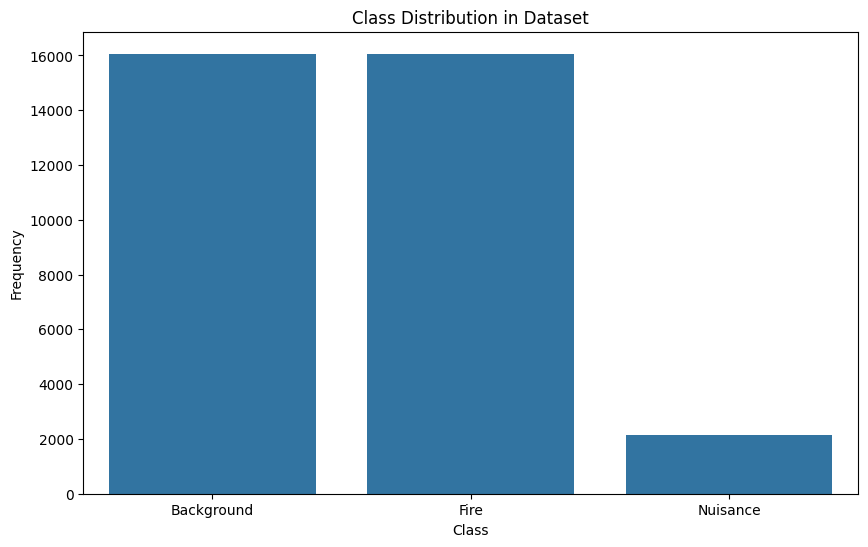

Background    16061
Fire          16061
Nuisance       2147
Name: ternary_label, dtype: int64


In [ ]:
class_counts = X1_train['ternary_label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Display the class distribution
print(class_counts)

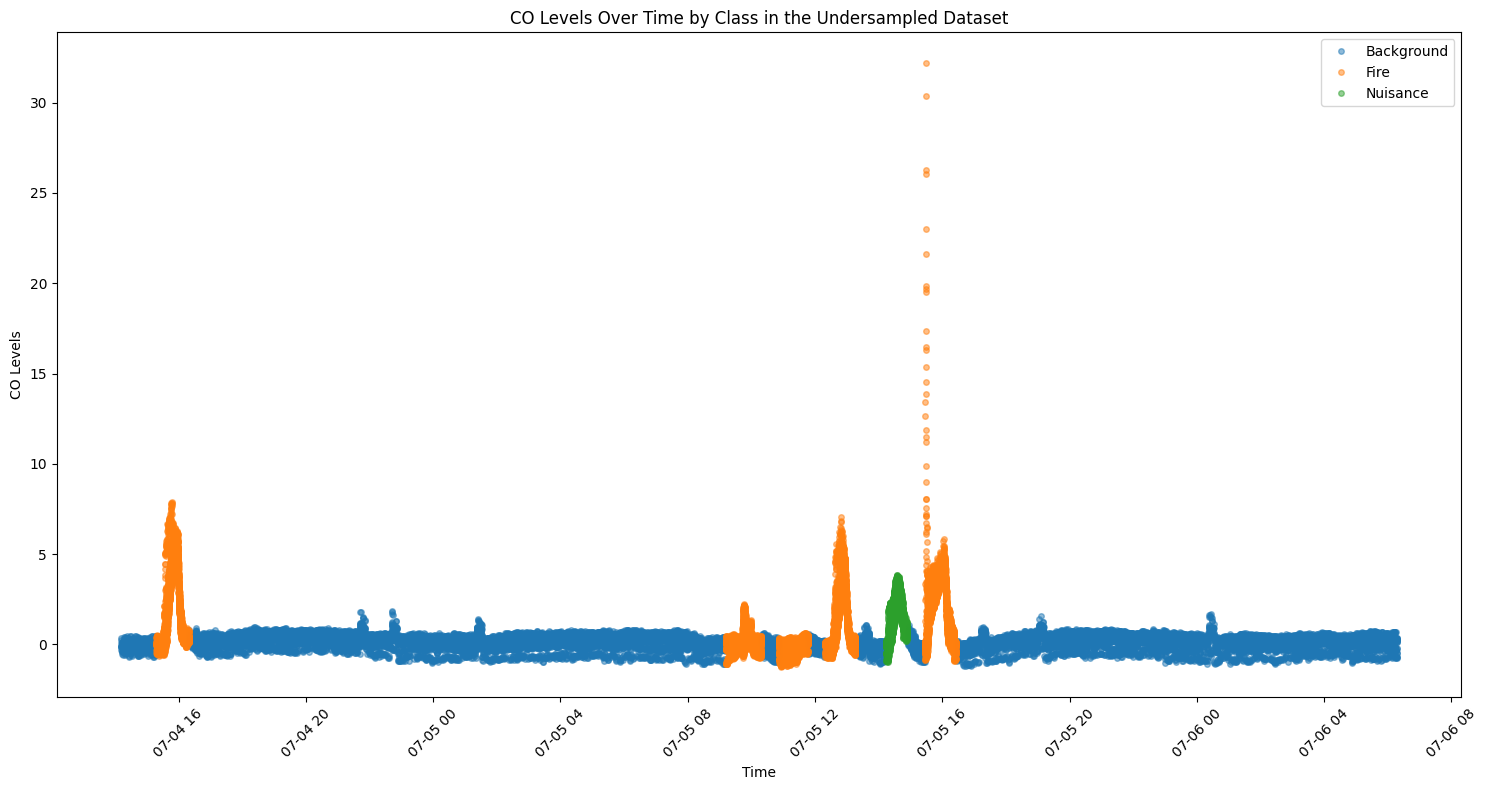

In [ ]:
# Convert 'Date' to datetime format for plotting
X1_train['Date'] = pd.to_datetime(X1_train['Date'])

plt.figure(figsize=(15, 8))

for label in X1_train['ternary_label'].unique():
    subset = X1_train[X1_train['ternary_label'] == label]
    plt.plot(subset['Date'], subset['CO_Room'], marker='o', linestyle='', alpha=0.5, ms=4, label=label)

plt.title('CO Levels Over Time by Class in the Undersampled Dataset')
plt.xlabel('Time')
plt.ylabel('CO Levels')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We will now remove the `Date` column from our features since we don't need it to train our model's later on.

In [ ]:
X1_train = X1_train.drop(columns='Date')
Xfe_val = Xfe_val.drop(columns='Date')
Xfe_test = Xfe_test.drop(columns='Date')

# Data Scaling

Some of the models we will use for our fire detection process are sensitive to data scaling, therefore we will scale our data accordingly.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

#Drop ternary labels

X1_train = X1_train.drop(columns = ['ternary_label'])
Xfe_val = Xfe_val.drop(columns = 'ternary_label')
Xfe_test = Xfe_test.drop(columns = 'ternary_label')

# Fit the scaler on the training data and transform the training data
Xfe_train_scaled = scaler.fit_transform(X1_train)

# Transform the validation data using the fitted scaler
Xfe_val_scaled = scaler.transform(Xfe_val)

#Transform the test data using the fitted scaler
Xfe_test_scaled = scaler.transform(Xfe_test)

In [ ]:
Xfe_train_scaled

array([[-0.21712361, -0.48555331, -0.19007884, ..., -0.2215944 ,
        -0.68260294, -0.09999108],
       [-0.21889387,  0.4412874 , -0.19253263, ..., -0.22350104,
        -0.68260294, -0.09999108],
       [-0.21673022,  0.81202369, -0.19007884, ..., -0.22135608,
        -0.68260294, -0.09999108],
       ...,
       [-0.22007405, -0.30018517, -0.19253263, ..., -0.22469268,
        -0.21193059, -0.09999108],
       [-0.22007405, -1.04165774, -0.19253263, ..., -0.22469268,
        -0.1691422 , -0.09999108],
       [-0.21889387, -1.04165774, -0.19253263, ..., -0.22350104,
        -0.21193059, -0.09999108]])

With that step we have finished the data preprocessing section and we can now test various models.

# Model Training and Evaluation

To construct a robust fire detection system, we will explore and evaluate a suite of machine learning algorithms, each with distinct characteristics and strengths. Our lineup includes K-Nearest Neighbors (KNN), Random Forest, Support Vector Machine (SVM), and Logistic Regression. These models span a range from simple, interpretable algorithms to more complex, ensemble-based approaches.

## Evaluation Metrics

For our evaluation, the priority will be placed on the recall metric for the 'Fire' class, given the critical nature of fire detection systems where missing an actual fire event (a false negative) can have dire consequences. Recall, also known as sensitivity or the true positive rate, measures the model's ability to correctly identify all positive instances of the 'Fire' class. A high recall indicates that the model is successful in capturing the majority of fire events, which is our primary concern.

While accuracy, precision, and F1-score will also be considered to provide a holistic view of model performance, they will be secondary to recall in this scenario. The focus on recall is due to the asymmetric cost associated with false negatives in fire detection, as failing to detect a fire is far more costly than incorrectly identifying a non-fire event as a fire (a false positive). We will also examine the ROC curve and calculate the AUC specifically for the 'Fire' class to assess the trade-off between the true positive rate and false positive rate at various threshold settings.

By emphasizing recall for the 'Fire' class in our evaluation metrics, we aim to ensure that the chosen model is optimized for the most crucial aspect of fire detection—maximizing the detection of actual fire events to enhance safety and response efficacy.

Furthermore, we will also calculate a variation of the F1 metric, called the F-beta score.

The F-beta score is a weighted harmonic mean of precision and recall, where the beta parameter determines the weight given to recall in the calculation. By choosing an F-beta score where beta is greater than 1, we can place more emphasis on recall relative to precision.

For instance, an F2 score (beta=2) weights recall twice as heavily as precision. This adjustment is crucial for our application because it quantifies a model's performance based on our specific cost-sensitive priority: minimizing false negatives. With the F2 score, we are explicitly stating that missing a fire event is much worse than incorrectly signaling one, which aligns with the primary goal of ensuring safety and prompt emergency response.

By utilizing the F-beta score with a beta greater than 1, we can more accurately reflect the performance of our models in accordance with the operational priorities of fire detection systems. It allows us to fine-tune the balance between precision and recall in a way that prioritizes the detection of all potential fire events, thus reinforcing the reliability and trustworthiness of our predictive modeling efforts.

The F-beta is expressin the following expression:


$$ F_{\beta} = (1 + \beta^2) \cdot \frac{{\text{precision} \cdot \text{recall}}}{{(\beta^2 \cdot \text{precision}) + \text{recall}}} $$

Where:

- Precision is the ratio of true positive predictions to the total predicted positives (true positives + false positives).
- Recall (also known as sensitivity or true positive rate) is the ratio of true positive predictions to the total actual positives (true positives + false negatives).
- $\beta$ (beta) is a parameter that indicates the weight given to recall in the combined score. A beta greater than 1 gives more weight to recall, while a beta less than 1 emphasizes precision.

For instance, when using an F2 score (where $\beta = 2$), we are considering recall to be twice as important as precision.

Alongside with the traditional evaluation metrics we will also calculate the confusion matrices and the ROC curve and calculate the AUC specifically for the 'Fire' class to assess the trade-off between the true positive rate and false positive rate at various threshold settings.

In [ ]:
from sklearn.metrics import classification_report, fbeta_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import seaborn as sns

beta = 3 #Start with the highest priority on recall, above that number precision loses its significance

## K-Nearest Neighbors

We'll start with KNN for its simplicity and effectiveness in capturing the local structure of the data. It's a non-parametric method that classifies each data point based on the majority label among its closest neighbors.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Initialize the KNN classifier with the n_neighbors equal to 5
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(Xfe_train_scaled, y1_train)
yt_pred_knn = knn.predict(Xfe_train_scaled)

yv_pred_knn = knn.predict(Xfe_val_scaled)

NameError: name 'Xfe_train_scaled' is not defined

### Evaluation of KNN

We will now evaluate our model's results on the training set and on the validation dataset.

We will showcase the classification report and the F3 score alongside with the confusion matrix containing the FP, FN, TN, TP.

Lastly, we will show the ROC containing the True Positive Rate vs False Positive Rate at various threshold settings.

In [ ]:
# Classification Report for our Training Data
print("KNN Report (Training Data):\n", classification_report(y1_train, yt_pred_knn))

# Weighted Average for our multiclass classification
f_beta_score = fbeta_score(y1_train, yt_pred_knn, beta=beta, average='weighted')
# Print the F-beta score and the classification report
print(f'F{beta}-score for the training set: {f_beta_score:.2f}')

KNN Report (Training Data):
               precision    recall  f1-score   support

  Background       0.99      0.98      0.98     16061
        Fire       0.98      0.99      0.99     16061
    Nuisance       0.97      0.96      0.97      2147

    accuracy                           0.98     34269
   macro avg       0.98      0.98      0.98     34269
weighted avg       0.98      0.98      0.98     34269

F3-score for the training set: 0.98


In [ ]:
# Classification Report for our Validation Data
print("KNN Report (Validation Data):\n", classification_report(y_val, yv_pred_knn))

f_beta_score = fbeta_score(y_val, yv_pred_knn, beta=beta, average='weighted')
# Print the F-beta score and the classification report
print(f'F{beta}-score for the training set: {f_beta_score:.2f}')

KNN Report (Validation Data):
               precision    recall  f1-score   support

  Background       0.96      0.87      0.92     68391
        Fire       0.41      0.92      0.56      5554
    Nuisance       0.61      0.48      0.54      4054

    accuracy                           0.86     77999
   macro avg       0.66      0.76      0.67     77999
weighted avg       0.90      0.86      0.87     77999

F3-score for the training set: 0.86


The KNN model's performance on the training data is exemplary across all classes, with an F3-score highlighting a strong recall.

However, when applied to the validation data, the model's recall for the 'Fire' class drops to 0.92, and for 'Nuisance' to 0.48, which suggests a decline in the model's ability to generalize from training to unseen data.

This drop, particularly in the recall for the 'Fire' class, is expected since the model's performance varies between the training and the validation dataset.

The overall high F3-score on the validation set shows promise, but the results indicate that the model may benefit from further optimization to enhance its predictive reliability for fire events.


Next, the confusion matrix for our validation data.

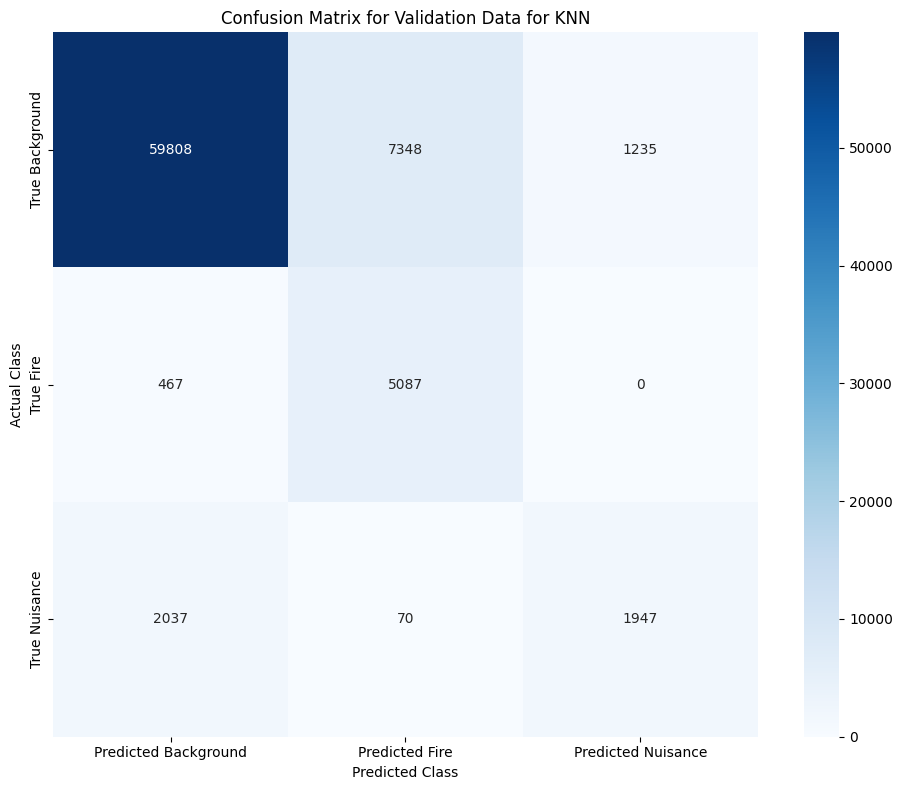

In [ ]:
X# Generate the confusion matrix
conf_matrix_val = confusion_matrix(y_val, yv_pred_knn)

# Create a pandas DataFrame from the numpy array and label the columns and index
conf_matrix_df = pd.DataFrame(conf_matrix_val,
                              index=['True Background', 'True Fire', 'True Nuisance'],
                              columns=['Predicted Background', 'Predicted Fire', 'Predicted Nuisance'])

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="Blues", square=True)
plt.title('Confusion Matrix for Validation Data for KNN')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()  # Adjust layout to fit the figure nicely
plt.show()


There is a high correct classification rate for the 'Background' class with 59,808 true positives. However, there are a significant number of 'Background' instances misclassified as 'Fire' (7,348) and 'Nuisance' (1,235), indicating a tendency of the model to produce false alarms.

The 'Fire' class sees a high number of true positives at 5,087, with a relatively low number of false negatives (467), suggesting that the KNN model is effectively recognizing fire events, which is vital for the primary goal of fire detection.

The model has a considerable challenge with the 'Nuisance' class, with 2,037 instances incorrectly labeled as 'Background' and only 1,947 correctly identified. The model also has few instances where 'Nuisance' is mistaken for 'Fire' (70), reflecting some difficulty in distinguishing between 'Nuisance' and 'Background' events.

Overall, the confusion matrix indicates that while the KNN classifier is capable of identifying fire events with a good degree of accuracy, there is a pronounced issue with false positives for the 'Background' class and a notable number of missed 'Nuisance' events.

We will now continue with the ROC plot.



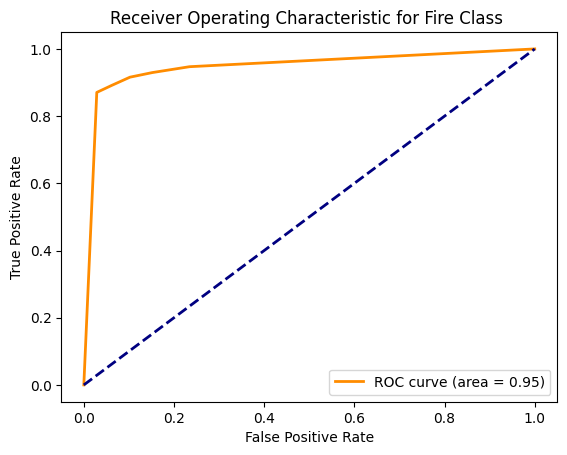

In [ ]:
# Get probability scores for the 'Fire' class
knn1_probs = knn.predict_proba(Xfe_val_scaled)[:, 1]

# Binarize the validation labels - we're interested in 'Fire' class
y1_val_binarized = label_binarize(y_val, classes=['Background', 'Fire', 'Nuisance'])[:, 1]

# Calculate the FPR, TPR, and thresholds for the 'Fire' class
fpr_knn1, tpr_knn1, thresholds_knn1 = roc_curve(y1_val_binarized, knn1_probs)

# Calculate the AUC for the 'Fire' class
roc_auc_knn1 = auc(fpr_knn1, tpr_knn1)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_knn1, tpr_knn1, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Fire Class ')
plt.legend()
plt.show()

The model exhibits a high area under the curve (AUC) of 0.95, which indicates a strong ability to distinguish between the Fire class and the other classes. Higher AUC values imply better model performance, and an AUC of 0.95 suggests that the model has a high true positive rate across various thresholds.

## Random Forest

Next, we'll evaluate the Random Forest classifier, an ensemble method known for its robustness and effectiveness across various types of data. It's particularly suited for complex datasets like ours, where the interactions between predictors can be intricate. By leveraging its ensemble approach, we aim to enhance predictive accuracy and reduce the risk of overfitting, with a keen focus on improving the recall for the 'Fire' class. This step is part of our ongoing effort to find the most reliable model for our fire detection system.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, random_state=0)

# Fit training data
rf.fit(Xfe_train_scaled, y1_train)

# Predict on training data
y1t_pred_rf = rf.predict(Xfe_train_scaled)

# Predict on Validation Data
y1_pred_rf = rf.predict(Xfe_val_scaled)



### Random Forest Evaluation

We will now evaluate our model's results on the training set and on the validation dataset.

We will showcase the classification report and the F3 score alongside with the confusion matrix containing the FP, FN, TN, TP.

Lastly, we will show the ROC containing the True Positive Rate vs False Positive Rate at various threshold settings.

In [ ]:
# Classification Report for our Training Data
print("RF Report (Training Data):\n", classification_report(y1_train, y1t_pred_rf))

# Weighted Average for our multiclass classification
f_beta_score = fbeta_score(y1_train, y1t_pred_rf, beta=beta, average='weighted')
# Print the F-beta score and the classification report
print(f'F{beta}-score for the training set: {f_beta_score:.2f}')

RF Report (Training Data):
               precision    recall  f1-score   support

  Background       1.00      1.00      1.00     16061
        Fire       1.00      1.00      1.00     16061
    Nuisance       1.00      1.00      1.00      2147

    accuracy                           1.00     34269
   macro avg       1.00      1.00      1.00     34269
weighted avg       1.00      1.00      1.00     34269

F3-score for the training set: 1.00


In [ ]:
# Classification Report for our Validation Data
print("RF Report (Validation Data):\n", classification_report(y_val, y1_pred_rf))

f_beta_score = fbeta_score(y_val, y1_pred_rf, beta=beta, average='weighted')
# Print the F-beta score and the classification report
print(f'F{beta}-score for the training set: {f_beta_score:.2f}')

NameError: name 'classification_report' is not defined

The Random Forest classifier has demonstrated perfect performance on the training data, achieving precision, recall, and F1-scores of 1.00 across all classes, which is also reflected in an F3-score of 1.00. That's expected since the model adjusted perfectly to the training data.

However, when applied to the validation data, we see some discrepancies. While the model performs well for the 'Background' class, the recall for the 'Fire' class is 0.96, indicating that the model misses some fire instances. For the 'Nuisance' class, the recall drops to 0.45, suggesting the model struggles to detect nuisance instances consistently, just like before in the KNN.

The overall F3-score of 0.91 on the validation data is strong but the results indicate that the model may benefit from further optimization to enhance its predictive reliability for fire events.

We will proceed with the confusion matrix.

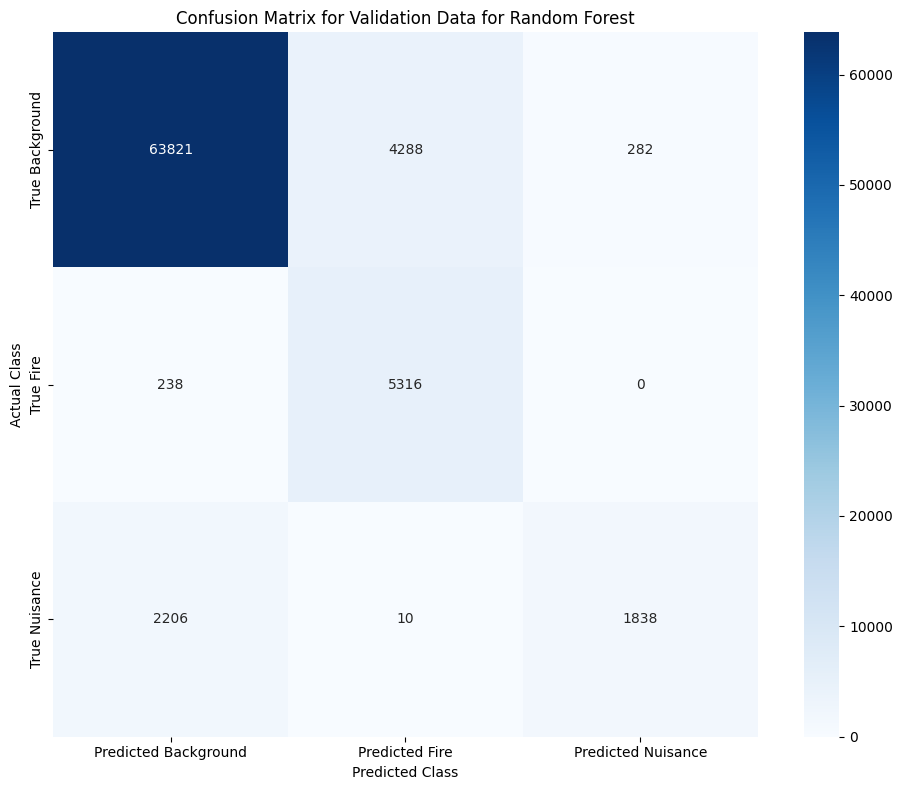

In [ ]:
# Generate the confusion matrix
conf_matrix_val = confusion_matrix(y_val, y1_pred_rf)

# Create a pandas DataFrame from the numpy array and label the columns and index
conf_matrix_df = pd.DataFrame(conf_matrix_val,
                              index=['True Background', 'True Fire', 'True Nuisance'],
                              columns=['Predicted Background', 'Predicted Fire', 'Predicted Nuisance'])

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="Blues", square=True)
plt.title('Confusion Matrix for Validation Data for Random Forest')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()  # Adjust layout to fit the figure nicely
plt.show()


The model has a high true positive rate for the 'Background' class, correctly classifying 63,821 instances, which underscores its capability to recognize the Background class effectively.

For the 'Fire' class, the model correctly identifies 5,316 instances, but there are 238 instances misclassified as 'Background', indicating a relatively high recall but with some room for improvement to catch more fire events. This is a better result compared to KNN.

The 'Nuisance' class demonstrates a significant number of false negatives, with 2,206 instances misclassified as 'Background', and no instances misclassified as 'Fire'. This suggests that while the model can identify 'Nuisance' events to some extent (1,838 correct), it often confuses them with 'Background' scenarios, which could be an area to focus on for model improvement.

Now let's proceed with the ROC plot.

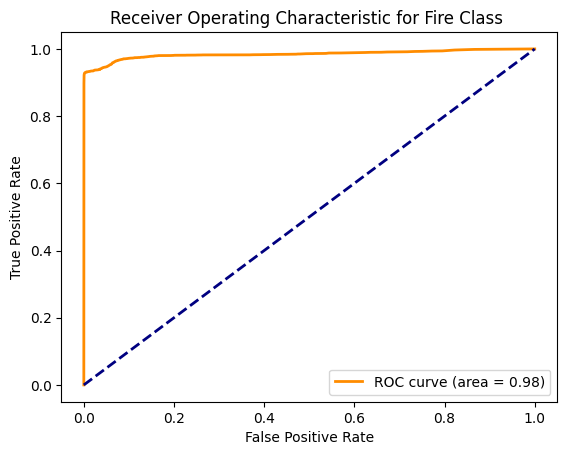

In [ ]:
# Get probability scores for the 'Fire' class
rf1_probs = rf.predict_proba(Xfe_val_scaled)[:, 1]

# Binarize the validation labels - we're interested in 'Fire' class
y1_val_binarized = label_binarize(y_val, classes=['Background', 'Fire', 'Nuisance'])[:, 1]

# Calculate the FPR, TPR, and thresholds for the 'Fire' class
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y1_val_binarized, rf1_probs)

# Calculate the AUC for the 'Fire' class
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Fire Class ')
plt.legend()
plt.show()


The ROC curve for the Fire class using the Random Forest model exhibits an excellent AUC of 0.98, indicating a very strong capability to distinguish between the Fire class and other classes.

The curve hugs the top left corner closely, reflecting a high true positive rate and a low false positive rate across different thresholds. Such an AUC value suggests that the model has a high degree of separability and can effectively identify fire events with a low likelihood of false alarms.

This performance is ideal for fire detection scenarios where the priority is to detect as many true fire instances as possible while minimizing false detections.

## Logistic Regression

Having observed the performance of KNN and Random Forest models, we now proceed to evaluate Logistic Regression. As a statistical model that predicts the probability of a binary outcome, Logistic Regression is particularly appealing for its simplicity and interpretability.

Despite its fundamental nature, it can serve as a strong baseline for classification problems, including our task of fire detection. We will apply Logistic Regression to our balanced dataset, carefully tuning it to prioritize recall for the 'Fire' class.

The model's performance will be gauged against the same evaluation metrics used for the previous models, providing us with a comparative perspective on its effectiveness in our specific context.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
# For multiclass problems, you can use the 'multinomial' option with 'lbfgs' solver
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1.0, max_iter=1000)

# Train on the selected features (X1)
log_reg.fit(Xfe_train_scaled, y1_train)

# Predict on the training dataset
yt_pred_log_reg = log_reg.predict(Xfe_train_scaled)

# Predict on the validation dataset
y_pred_log_reg = log_reg.predict(Xfe_val_scaled)


### Logistic Regression Evaluation

We will now evaluate our model's results on the training set and on the validation dataset.

We will showcase the classification report and the F3 score alongside with the confusion matrix containing the FP, FN, TN, TP.

Lastly, we will show the ROC containing the True Positive Rate vs False Positive Rate at various threshold settings.

In [ ]:
# Classification Report for our Training Data
print("Logistic Regression Report (Training Data):\n", classification_report(y1_train, yt_pred_log_reg))

# Weighted Average for our multiclass classification
f_beta_score = fbeta_score(y1_train, yt_pred_log_reg, beta=beta, average='weighted')
# Print the F-beta score and the classification report
print(f'F{beta}-score for the training set: {f_beta_score:.2f}')

Logistic Regression Report (Training Data):
               precision    recall  f1-score   support

  Background       0.92      0.96      0.94     16061
        Fire       0.96      0.94      0.95     16061
    Nuisance       0.99      0.80      0.88      2147

    accuracy                           0.94     34269
   macro avg       0.96      0.90      0.92     34269
weighted avg       0.94      0.94      0.94     34269

F3-score for the training set: 0.94


In [ ]:
# Classification Report for our Training Data
print("Logistic Regression Report (Validation Data):\n", classification_report(y_val, y_pred_log_reg))

# Weighted Average for our multiclass classification
f_beta_score = fbeta_score(y_val, y_pred_log_reg, beta=beta, average='weighted')
# Print the F-beta score and the classification report
print(f'F{beta}-score for the validation set: {f_beta_score:.2f}')

Logistic Regression Report (Validation Data):
               precision    recall  f1-score   support

  Background       0.96      0.93      0.94     68391
        Fire       0.52      0.96      0.67      5554
    Nuisance       0.95      0.47      0.63      4054

    accuracy                           0.90     77999
   macro avg       0.81      0.79      0.75     77999
weighted avg       0.93      0.90      0.91     77999

F3-score for the validation set: 0.90


On the training data, the model shows high precision and recall across all classes with an overall F3-score of 0.94, indicating a strong performance with a slight bias towards recall. This is evidenced by high recall scores, particularly for the 'Background' class.

Moving to the validation data, the model maintains a commendable recall of 0.96 for the 'Fire' class. The precision not hight at all at 0.52, leading to an F1-score of 0.67 for the 'Fire' class.

The 'Nuisance' class, however, exhibits a much lower recall of 0.47 on the validation data, suggesting that the model is less adept at identifying 'Nuisance' instances compared to 'Background' and 'Fire' classes. We notice the same drop in this metric in the previous classifiers as well.

The F3-score for the validation set stands at 0.90, due the low recall on the Nuisance class.

We will proceed with the confusion matrix.

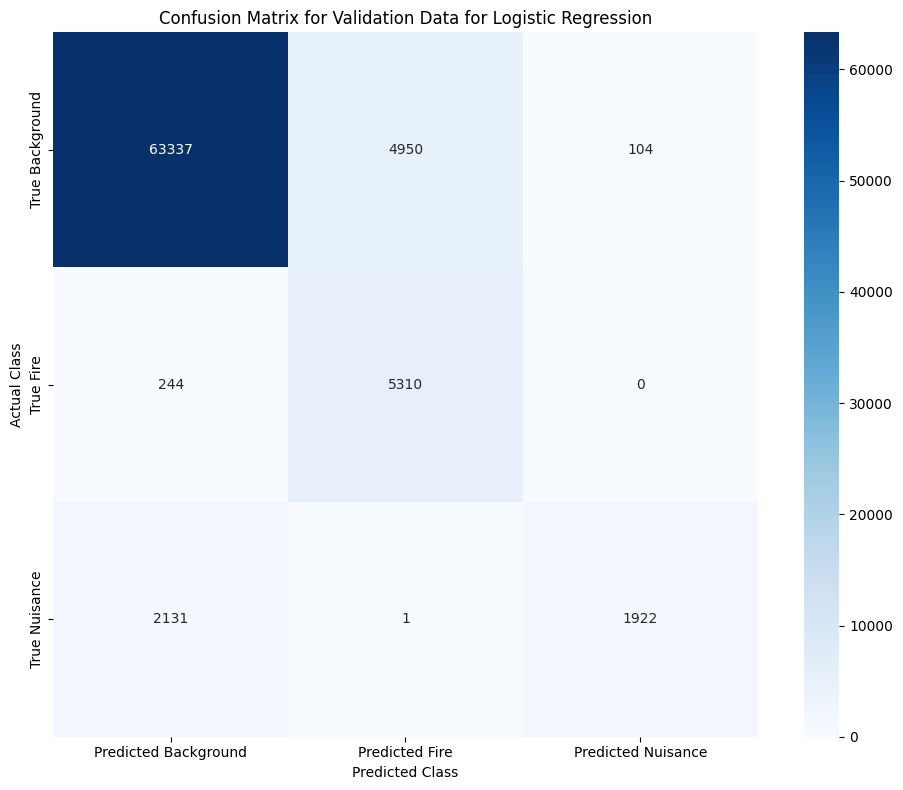

In [ ]:
# Generate the confusion matrix
conf_matrix_val = confusion_matrix(y_val, y_pred_log_reg)

# Create a pandas DataFrame from the numpy array and label the columns and index
conf_matrix_df = pd.DataFrame(conf_matrix_val,
                              index=['True Background', 'True Fire', 'True Nuisance'],
                              columns=['Predicted Background', 'Predicted Fire', 'Predicted Nuisance'])

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="Blues", square=True)
plt.title('Confusion Matrix for Validation Data for Logistic Regression')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()  # Adjust layout to fit the figure nicely
plt.show()

The confusion matrix for the Logistic Regression model on the validation data reveals:

The model is highly effective at identifying the 'Background' class with a substantial number of true positives (63,337) and relatively few instances misclassified as 'Fire' (4,950) or 'Nuisance' (104).

In detecting the 'Fire' class, the model demonstrates strong performance with 5,310 true positives, while it misclassifies only a small number of 'Fire' instances as 'Background' (244). This indicates a high recall for the 'Fire' class, which is critical in a fire detection context where missing a true fire is extremely costly.

The model struggles more with the 'Nuisance' class, with a notable portion of 'Nuisance' instances being incorrectly predicted as 'Background' (2,131). However, it correctly identifies 1,922 'Nuisance' instances and hardly confuses them for 'Fire' events (1 instance), suggesting some degree of precision but lower recall for this class.

The matrix reveals that while the model's ability to detect fires is robust, improving the recognition of 'Nuisance' events without compromising the detection of 'Fire' events would be beneficial.

We will proceed with the ROC plot.

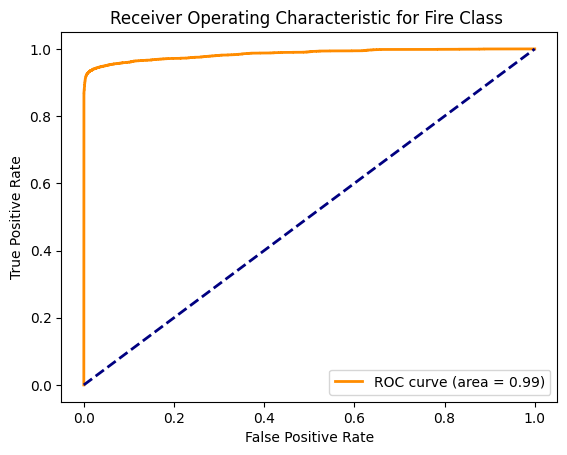

In [ ]:
# Get probability scores for the 'Fire' class
log_reg_probs = log_reg.predict_proba(Xfe_val_scaled)[:, 1]

# Binarize the validation labels - we're interested in 'Fire' class
y1_val_binarized = label_binarize(y_val, classes=['Background', 'Fire', 'Nuisance'])[:, 1]

# Calculate the FPR, TPR, and thresholds for the 'Fire' class
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y1_val_binarized, log_reg_probs)

# Calculate the AUC for the 'Fire' class
roc_auc_log_reg = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_log_reg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Fire Class ')
plt.legend()
plt.show()

An impressive AUC of 0.99, indicating an excellent ability of the model to differentiate between the Fire class and other classes. Althought that could be an indication of overfitting, we will cross validate this in the test set.

### Support Vector Machine

With insights gained from the previous classifiers, we now advance to the Support Vector Machine (SVM). SVM is known for its ability to find the optimal hyperplane that maximizes the margin between different classes, making it a powerful tool for classification tasks.

Its effectiveness in high-dimensional spaces and versatility in handling various types of data make it a promising option for our fire detection dataset. By applying an SVM, we aim to leverage its capacity for creating complex models that can accurately distinguish between classes, especially in critical 'Fire' detection scenarios.

We will train the SVM with the same careful consideration for class balance and evaluate its performance, looking closely at the recall for the 'Fire' class to ensure the model minimizes false negatives in fire predictions.

In [ ]:
from sklearn.svm import SVC

#svm trained on Xfe features
clf1 = SVC(decision_function_shape='ovr', C=10, kernel='linear' )

clf1.fit(Xfe_train_scaled, y1_train)


yt_pred_svm = clf1.predict(Xfe_train_scaled)

y_pred_svm = clf1.predict(Xfe_val_scaled)


In [ ]:
print("SVM Report (Training Data):\n",classification_report(y1_train, yt_pred_svm))

# Weighted Average for our multiclass classification
f_beta_score = fbeta_score(y1_train, yt_pred_svm, beta=beta, average='weighted')
# Print the F-beta score and the classification report
print(f'F{beta}-score for the Training set: {f_beta_score:.2f}')

SVM Report (Training Data):
               precision    recall  f1-score   support

  Background       0.92      0.98      0.95     16061
        Fire       0.98      0.94      0.96     16061
    Nuisance       1.00      0.80      0.88      2147

    accuracy                           0.95     34269
   macro avg       0.96      0.90      0.93     34269
weighted avg       0.95      0.95      0.95     34269

F3-score for the Training set: 0.95


In [ ]:
print("SVM Report (Validation Data):\n",classification_report(y_val, y_pred_svm))

# Weighted Average for our multiclass classification
f_beta_score = fbeta_score(y_val, y_pred_svm, beta=beta, average='weighted')
# Print the F-beta score and the classification report
print(f'F{beta}-score for the validation set: {f_beta_score:.2f}')

SVM Report (Validation Data):
               precision    recall  f1-score   support

  Background       0.97      0.98      0.98     68391
        Fire       0.84      0.97      0.90      5554
    Nuisance       0.99      0.45      0.62      4054

    accuracy                           0.96     77999
   macro avg       0.93      0.80      0.83     77999
weighted avg       0.96      0.96      0.95     77999

F3-score for the validation set: 0.95


On the training set, the SVM achieves high precision and recall across all classes, with a notable F3-score of 0.95. This suggests that while the model is biased towards recall, it does not severely compromise on precision, maintaining a balanced performance.

In the validation set, the SVM maintains high precision for all classes and an impressive recall of 0.97 for the 'Fire' class. The F1-score for the 'Fire' class is also strong at 0.90, reflecting a well-rounded ability to identify fire events.

However, the 'Nuisance' class shows a lower recall of 0.45 on the validation set, indicating that the model tends to miss a significant number of nuisance instances. Despite the high precision, this low recall suggests that the model is not as effective at recognizing nuisance events as it is with fire events.

Overall, the SVM model demonstrates a commendable capability to identify fire events, aligning with our primary objective. The lower recall for the 'Nuisance' class suggests that additional feature engineering or model tuning might be necessary to improve the model's ability to differentiate between nuisance and non-nuisance events.

We will proceed with the confusion matrix.

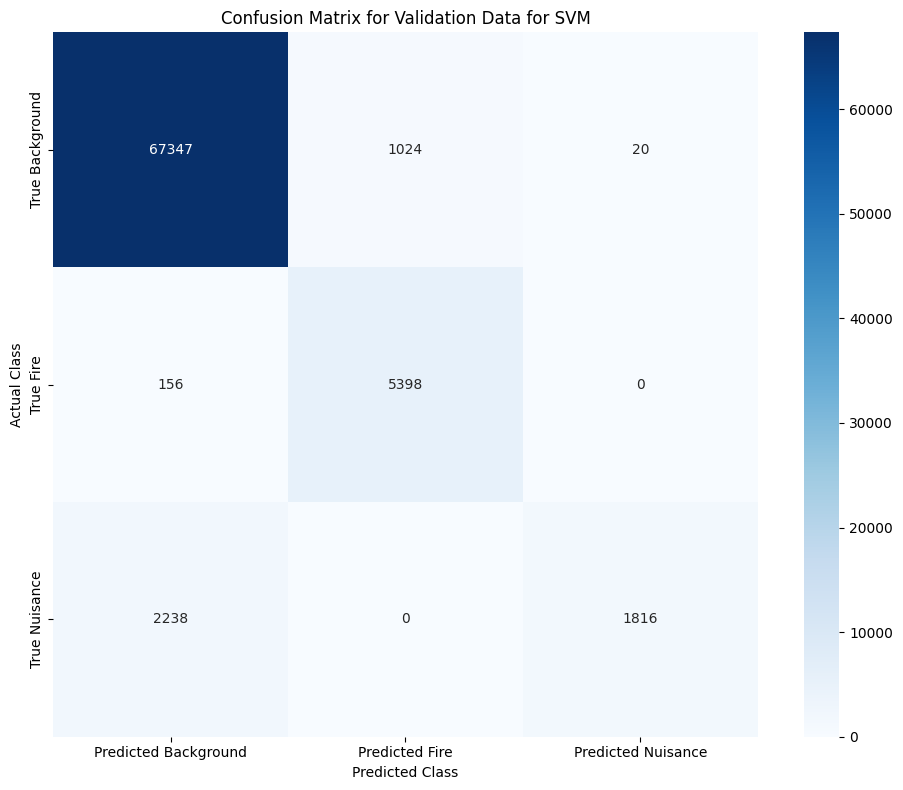

In [ ]:
# Generate the confusion matrix
conf_matrix_val = confusion_matrix(y_val, y_pred_svm)

# Create a pandas DataFrame from the numpy array and label the columns and index
conf_matrix_df = pd.DataFrame(conf_matrix_val,
                              index=['True Background', 'True Fire', 'True Nuisance'],
                              columns=['Predicted Background', 'Predicted Fire', 'Predicted Nuisance'])

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="Blues", square=True)
plt.title('Confusion Matrix for Validation Data for SVM')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()  # Adjust layout to fit the figure nicely
plt.show()

We can notice certain improvements from our previous models with 5398 correct fire predictions and 156 falsely predicted to background. This is an indicator that this model suits best our case.

For the ROC plot.


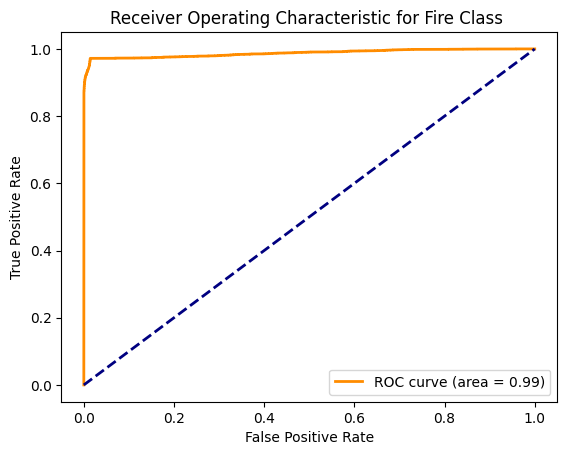

In [ ]:
#Curve only for the selected features
decision_scores = clf1.decision_function(Xfe_val_scaled)[:, 1]

# Binarize the validation labels - we're interested in 'Fire' class
y1_val_binarized = label_binarize(y_val, classes=['Background', 'Fire', 'Nuisance'])[:, 1]

# Calculate the FPR, TPR, and thresholds for the 'Fire' class
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y1_val_binarized, decision_scores)

# Calculate the AUC for the 'Fire' class
roc_auc_svm = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Fire Class ')
plt.legend()
plt.show()

The AUC is promising at 0.99. Although the clearest evaluation metric remains the confusion matrix.

## Model Comparison

From the above metrics, it's clear the the SVM performed better than the rest classifiers. Although, the evaluation metric which indicates its superiority is the recall for the fire class. So bellow, we have all the recall values for each class for each model separataly, which again, showcases that SVM outperformed the rest.

| Model               | Background Recall | Fire Recall | Nuisance Recall |
|---------------------|-------------------|-------------|-----------------|
| K-Nearest Neighbors | 0.87              | 0.92        | 0.48            |
| Random Forest       | 0.93              | 0.96        | 0.45            |
| Logistic Regression | 0.93              | 0.96        | 0.47            |
| Support Vector Machine (SVM) | 0.98      | 0.97        | 0.45            |


# Evaluation on Test Dataset

Having established the Support Vector Machine (SVM) as the best-performing model based on recall values for the 'Fire' class in our validation data, we will now deploy this model to predict outcomes on our test dataset. This dataset, which the model has not previously encountered, will serve as a new ground to evaluate the SVM's ability to generalize and perform under real-world conditions.

The test dataset, carefully partitioned from the rest to include the last two fire scenarios, will provide the ultimate test for our SVM model's predictive power. We will assess the model's performance using the same metrics applied during the validation phase, with a particular emphasis on recall for the 'Fire' class to ensure that the model reliably detects fire events, minimizing the risk of false negatives, which are critically important in the context of fire detection.

By applying the SVM model to this unseen data, we will gain valuable insights into how the model is likely to perform in an operational setting, providing us with a realistic measure of its efficacy.

In [ ]:
# Predict on test values
y_pred_svm_test = clf1.predict(Xfe_test_scaled)

### Evaluation Metrics - Classification Report

In [ ]:
print("SVM Report (Test Data):\n",classification_report(y_test, y_pred_svm_test))

# Weighted Average for our multiclass classification
f_beta_score = fbeta_score(y_test, y_pred_svm_test, beta=beta, average='weighted')
# Print the F-beta score and the classification report
print(f'F{beta}-score for the test set: {f_beta_score:.2f}')

SVM Report (Test Data):
               precision    recall  f1-score   support

  Background       0.98      0.89      0.94     73142
        Fire       0.63      0.98      0.77     16533
    Nuisance       1.00      0.66      0.80      7628

    accuracy                           0.89     97303
   macro avg       0.87      0.84      0.83     97303
weighted avg       0.92      0.89      0.90     97303

F3-score for the test set: 0.89


The classification report showcases the following insights:

**High Recall for Fire**: The SVM model has achieved a very high recall of 0.98 for the 'Fire' class, which is the most critical aspect for the fire detection system. This indicates that the model is highly capable of identifying most of the actual fire instances, with very few false negatives.

**Lower Precision for Fire**: The precision for the 'Fire' class is relatively low at 0.63. This suggests that while the model is good at catching fire events, it also has a higher number of false positives; that is, it sometimes incorrectly predicts a fire when there isn't one.

**Background Classification**: The 'Background' class shows strong precision and recall, indicating the model's effectiveness in correctly identifying non-fire events.

**Nuisance Class Challenges**: The model perfectly classifies the 'Nuisance' class when it predicts it (precision of 1.00), but the recall is 0.66, meaning the model misses about one-third of the actual nuisance instances.

**Overall Performance**: The F3-score for the test set is 0.89, which is a strong score that emphasizes recall, although it's slightly lower than the F3-score observed on the validation set, suggesting some loss in performance when generalizing to unseen data.

### Evaluation Metrics - Classification Report


We will also see the confusion matrix for our predictions.

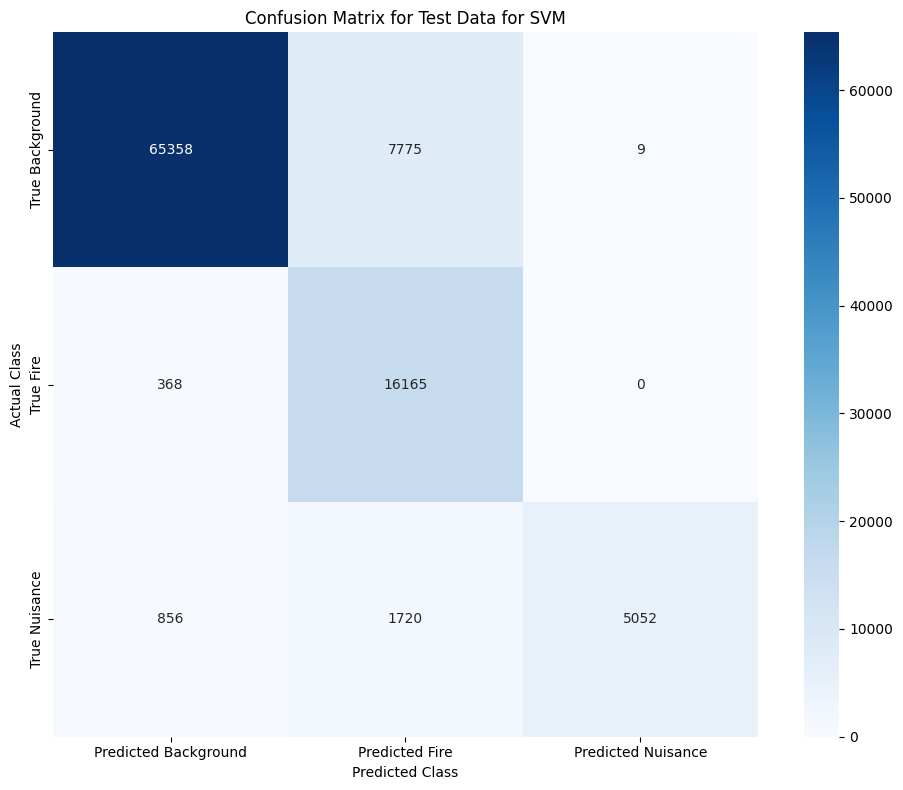

In [ ]:
# Generate the confusion matrix
conf_matrix_val = confusion_matrix(y_test, y_pred_svm_test)

# Create a pandas DataFrame from the numpy array and label the columns and index
conf_matrix_df = pd.DataFrame(conf_matrix_val,
                              index=['True Background', 'True Fire', 'True Nuisance'],
                              columns=['Predicted Background', 'Predicted Fire', 'Predicted Nuisance'])

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="Blues", square=True)
plt.title('Confusion Matrix for Test Data for SVM')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()  # Adjust layout to fit the figure nicely
plt.show()

From the above confusion matrix we can see:


A dominant performance in correctly predicting the 'Background' class with 65,358 true positives, alongside a moderate number of these instances being misclassified as 'Fire' (7,775).

An excellent recall for the 'Fire' class is observed with 16,165 true positives, which aligns with the model's objective of accurately detecting fire instances. The relatively low number of false negatives for 'Fire' (368) indicates that the SVM is highly effective in identifying actual fire events.

The 'Nuisance' class has a substantial number of instances (856) misclassified as 'Background', indicating challenges in detecting nuisance occurrences. However, the model does correctly identify 5,052 true positives for 'Nuisance', which is significant.

### Evaluation Metrics - ROC / AUC

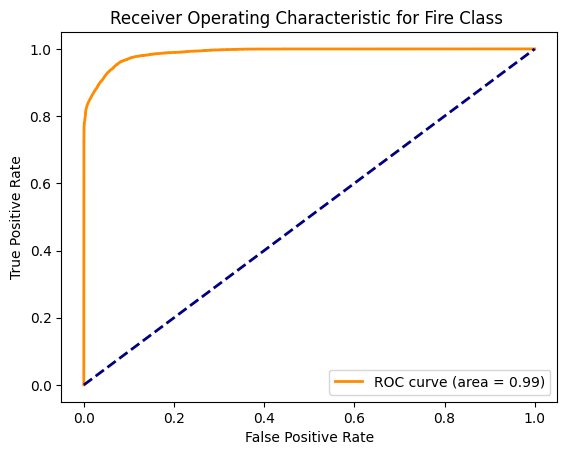

In [ ]:
#Curve only for the selected features
decision_scores = clf1.decision_function(Xfe_test_scaled)[:, 1]

# Binarize the validation labels - we're interested in 'Fire' class
y1_test_binarized = label_binarize(y_test, classes=['Background', 'Fire', 'Nuisance'])[:, 1]

# Calculate the FPR, TPR, and thresholds for the 'Fire' class
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y1_test_binarized, decision_scores)

# Calculate the AUC for the 'Fire' class
roc_auc_svm = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Fire Class ')
plt.legend()
plt.show()

The ROC curve displayed for the Fire class showcases an really good model performance with an AUC (Area Under the Curve) of 0.99, same as validation.

This near-perfect AUC reflects the model's exceptional ability to differentiate between the Fire class and other classes, indicating a high true positive rate across various threshold levels.

# Final Remarks

Throughout our comprehensive analysis, we successfully harnessed machine learning models to identify fire events within our dataset, with the Support Vector Machine (SVM) emerging as the most proficient in terms of recall for the 'Fire' class. This high recall is critical in fire detection, where the cost of missing an actual fire is exceedingly high. However, the models consistently demonstrated a lower recall for the 'Nuisance' class, which can likely be attributed to the class imbalance issue—'Nuisance' being the minority class after undersampling. Such imbalance often challenges models to learn the less represented classes effectively.

Moreover, our model's performance presents an opportunity for enhancement through hyperparameter tuning. By refining the model's parameters, we stand to improve precision and recall, especially for the minority class, thus further increasing the model's predictive accuracy and reliability. This tuning, coupled with techniques to address the class imbalance, such as advanced resampling methods or cost-sensitive learning, could yield significant improvements in future iterations of the fire detection system.